In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

## NN Model

In [5]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 250, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 3)
        self.cnn_pep_3 = nn.Conv1d(100, 250, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 550)
        self.fc2 = nn.Linear(550, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc3(self.fc2(self.fc1(x)))
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_5 = nn.Conv1d(200, 400, 1)
        self.cnn_apt_6 = nn.Conv1d(400, 800, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 1)
        self.cnn_pep_4 = nn.Conv1d(200, 400, 1)
        self.cnn_pep_5 = nn.Conv1d(400, 800, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x
        

In [9]:
class SingleAlphabetNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetNet, self).__init__()
        self.name = "SingleAlphabetNet"
        
        self.cnn_1 = nn.Conv1d(24, 25, 3) 
        self.cnn_2 = nn.Conv1d(25, 50, 3)
        self.cnn_3 = nn.Conv1d(50, 100, 3)
        self.cnn_4 = nn.Conv1d(100, 200, 3)
        self.cnn_5 = nn.Conv1d(200, 400, 1)
        self.cnn_6 = nn.Conv1d(400, 800, 1)
        
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))        

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [10]:
class SingleAlphabetComplexNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetComplexNet, self).__init__()
        self.name = "SingleAlphabetComplexNet"
        
        self.cnn_1 = nn.Conv1d(24, 50, 3) 
        self.cnn_2 = nn.Conv1d(50, 100, 3)
        self.cnn_3 = nn.Conv1d(100, 200, 3)
        self.cnn_4 = nn.Conv1d(200, 400, 3)
        self.cnn_5 = nn.Conv1d(400, 800, 3)
        self.cnn_6 = nn.Conv1d(800, 1000, 3, padding=2)
        self.cnn_7 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_8 = nn.Conv1d(800, 700, 3, padding=2)
        self.cnn_9 = nn.Conv1d(700, 500, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))
        pair = self.pool1(self.relu(self.cnn_7(pair))) 
        pair = self.pool1(self.relu(self.cnn_8(pair)))
        pair = self.pool1(self.relu(self.cnn_9(pair))) 

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [12]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([label]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') #(40, 4)
        pep = one_hot(pep, seq_type='peptide') #(8, 20)
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
        label = torch.FloatTensor([label]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/loss.png' %model_name, bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/accuracy.png' %model_name, bbox_inches='tight')
    plt.show()

In [13]:
# Test the regular one_hot method
oh = one_hot('LL', seq_type='peptide')
print(str(oh.shape))

(2, 20)


In [14]:
# Test the one_hot method
oh = one_hot(["GGGG", "LL"], single_alphabet=True)

## Binary Classification

In [15]:
def classifier(model, 
               train, 
               val,
               lr,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=5e-3)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        scheduler.step()
        print("Starting epoch: %d" %epoch, " with learning rate: ", scheduler.get_lr())
        for (apt, pep, label) in train:
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name)
                plot_accuracy(iters, train_acc, val_acc, model_name)
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %epoch)
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Starting epoch: 0  with learning rate:  [0.1]


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


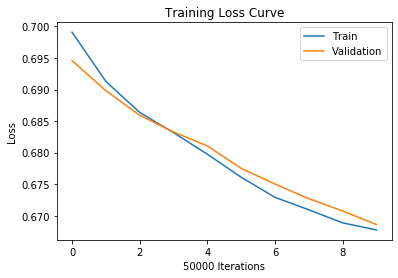

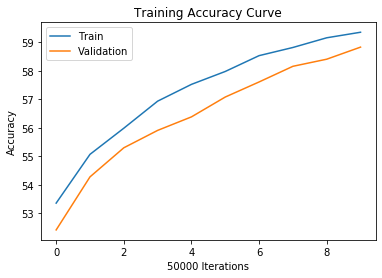

Training Accuracy at epoch 0: 59.352
Validation Accuracy epoch 0: 58.83


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


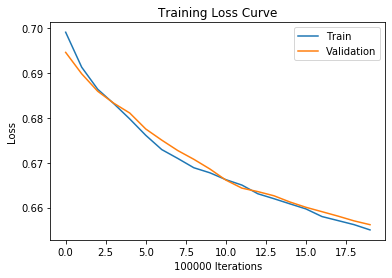

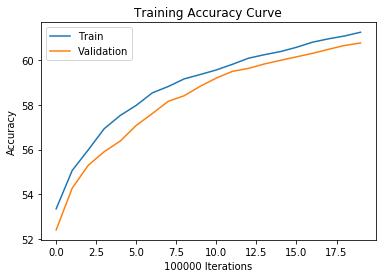

Training Accuracy at epoch 0: 61.236
Validation Accuracy epoch 0: 60.758


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


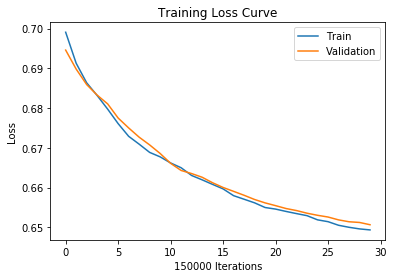

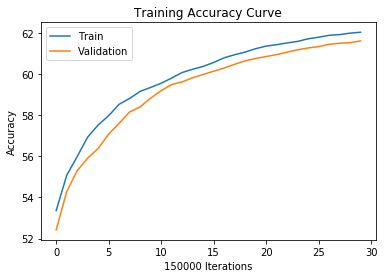

Training Accuracy at epoch 0: 62.036
Validation Accuracy epoch 0: 61.614


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


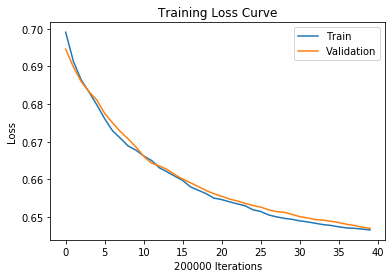

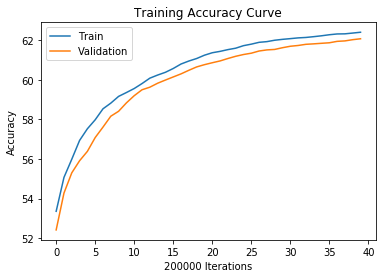

Training Accuracy at epoch 0: 62.3945
Validation Accuracy epoch 0: 62.065


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


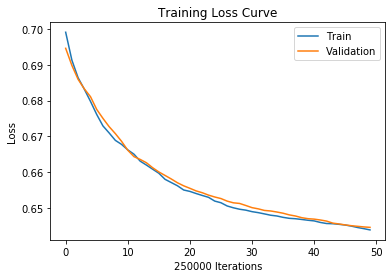

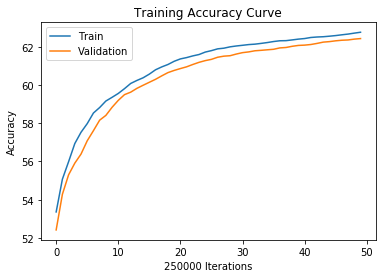

Training Accuracy at epoch 0: 62.754
Validation Accuracy epoch 0: 62.4228


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


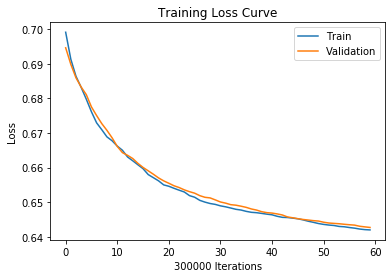

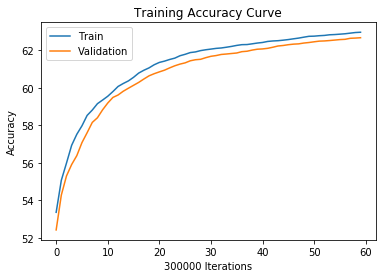

Training Accuracy at epoch 0: 62.971
Validation Accuracy epoch 0: 62.678


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


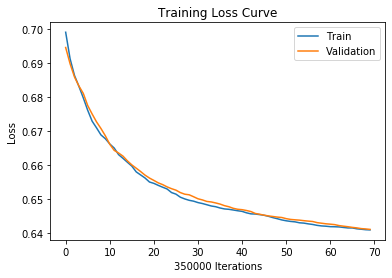

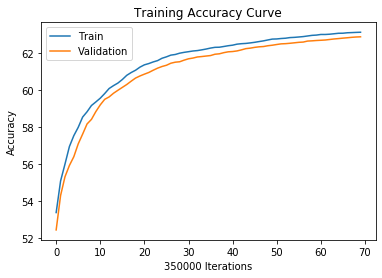

Training Accuracy at epoch 0: 63.125142857142855
Validation Accuracy epoch 0: 62.87771428571428


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


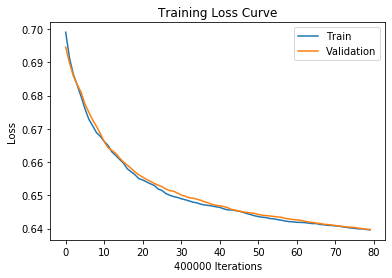

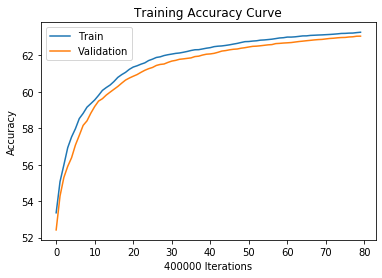

Training Accuracy at epoch 0: 63.2705
Validation Accuracy epoch 0: 63.05525


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


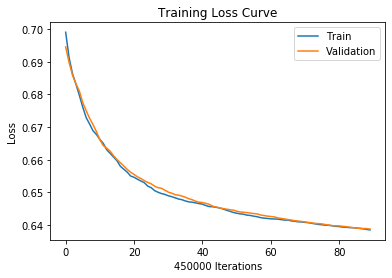

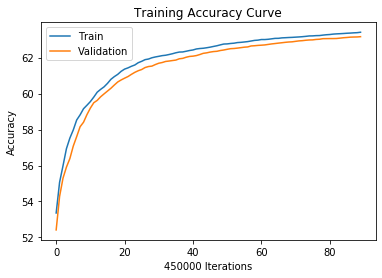

Training Accuracy at epoch 0: 63.41
Validation Accuracy epoch 0: 63.163111111111114


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


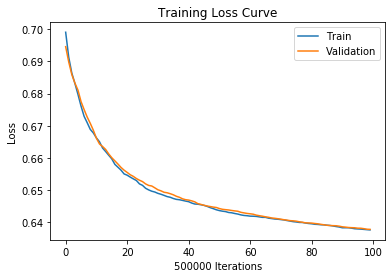

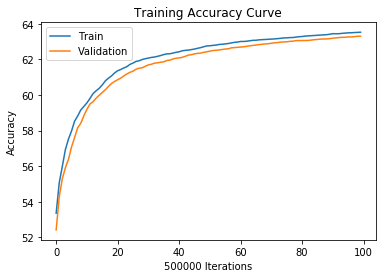

Training Accuracy at epoch 0: 63.5226
Validation Accuracy epoch 0: 63.2992


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


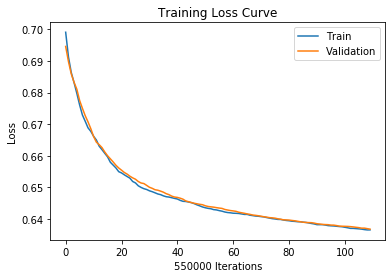

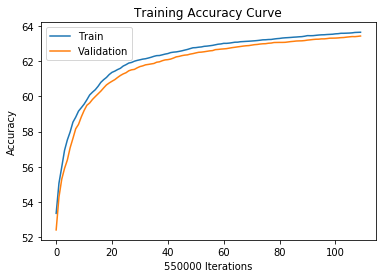

Training Accuracy at epoch 0: 63.634727272727275
Validation Accuracy epoch 0: 63.42036363636364


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


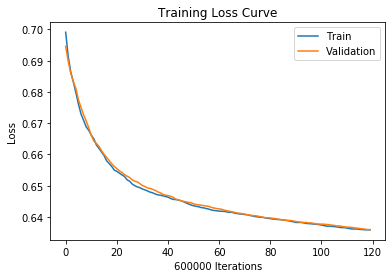

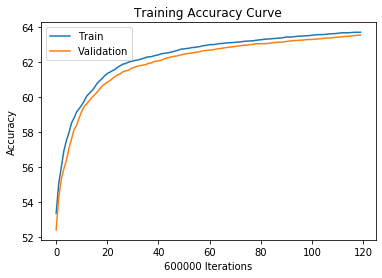

Training Accuracy at epoch 0: 63.71383333333333
Validation Accuracy epoch 0: 63.55083333333334


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


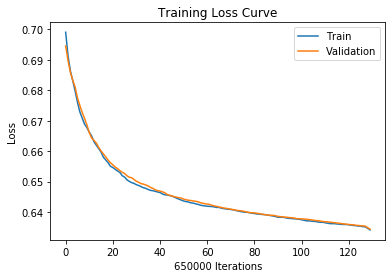

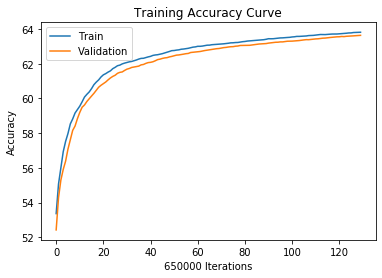

Training Accuracy at epoch 0: 63.815384615384616
Validation Accuracy epoch 0: 63.63676923076923


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


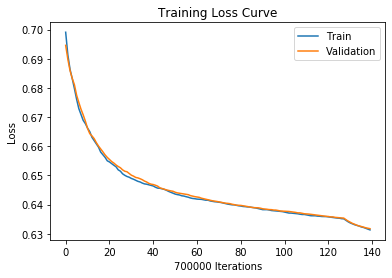

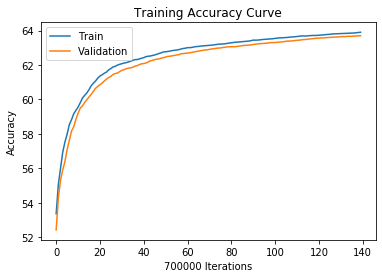

Training Accuracy at epoch 0: 63.899
Validation Accuracy epoch 0: 63.69871428571429


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


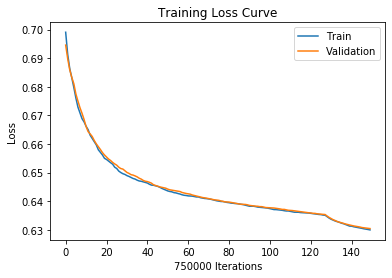

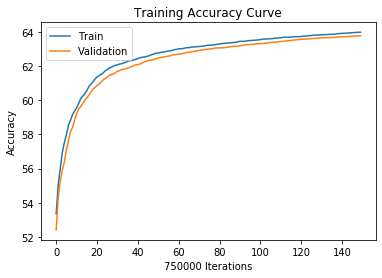

Training Accuracy at epoch 0: 63.970666666666666
Validation Accuracy epoch 0: 63.76533333333333


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


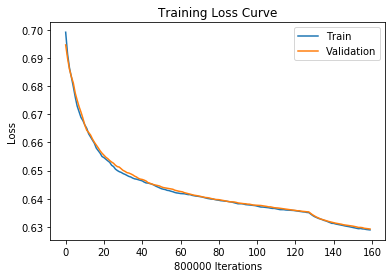

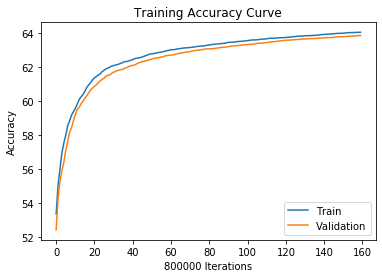

Training Accuracy at epoch 0: 64.031125
Validation Accuracy epoch 0: 63.843625


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


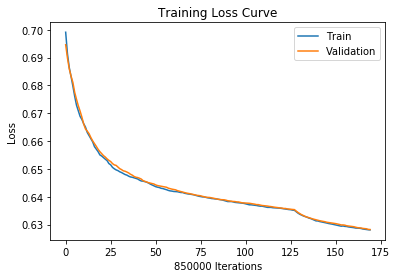

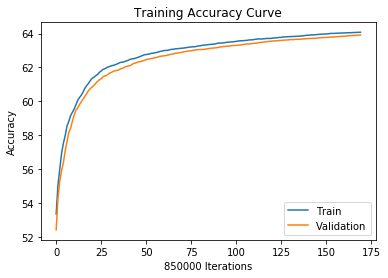

Training Accuracy at epoch 0: 64.07870588235293
Validation Accuracy epoch 0: 63.91705882352941


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


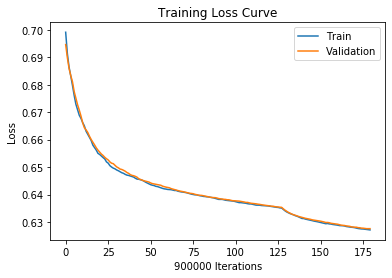

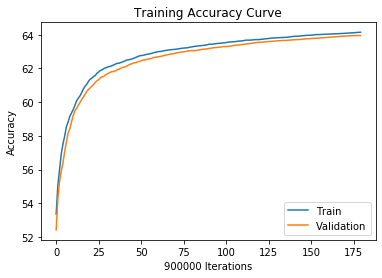

Training Accuracy at epoch 0: 64.15055555555556
Validation Accuracy epoch 0: 63.958555555555556


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 1  with learning rate:  [0.1]


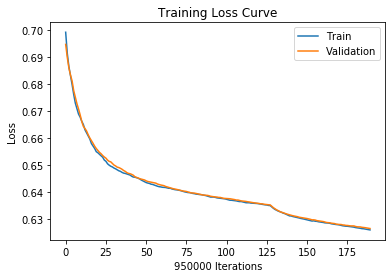

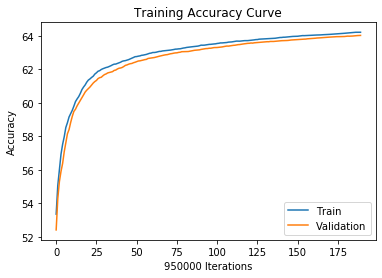

Training Accuracy at epoch 1: 64.21221052631579
Validation Accuracy epoch 1: 64.024


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


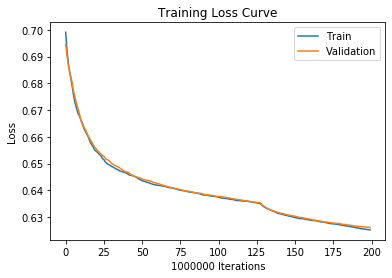

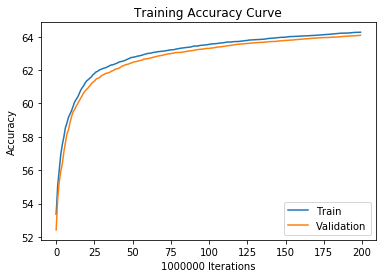

Training Accuracy at epoch 1: 64.2694
Validation Accuracy epoch 1: 64.088


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


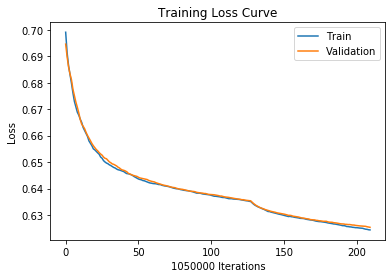

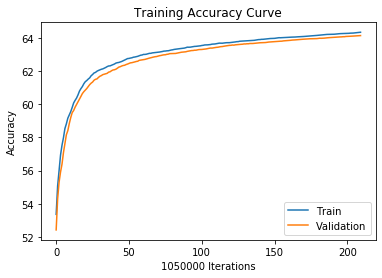

Training Accuracy at epoch 1: 64.34228571428571
Validation Accuracy epoch 1: 64.1407619047619


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


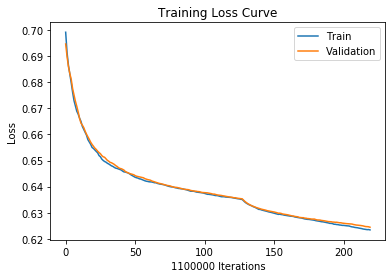

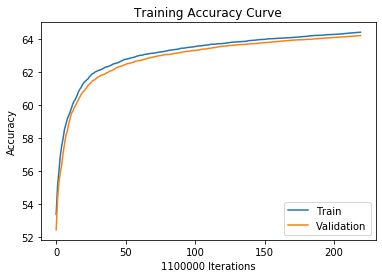

Training Accuracy at epoch 1: 64.40645454545455
Validation Accuracy epoch 1: 64.20618181818182


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


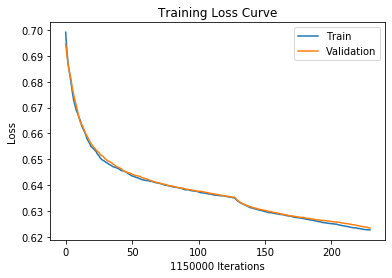

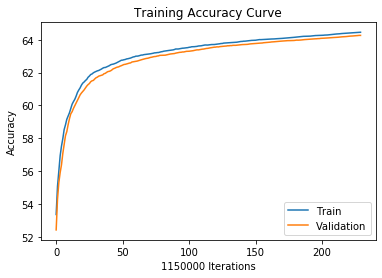

Training Accuracy at epoch 1: 64.46052173913043
Validation Accuracy epoch 1: 64.26869565217392


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


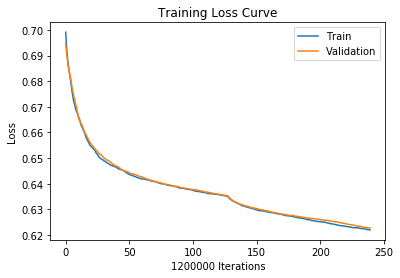

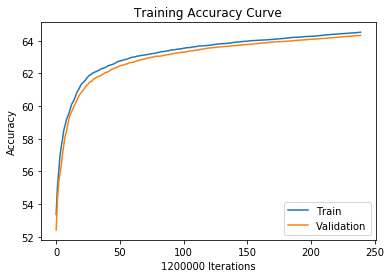

Training Accuracy at epoch 1: 64.52533333333334
Validation Accuracy epoch 1: 64.33683333333333


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


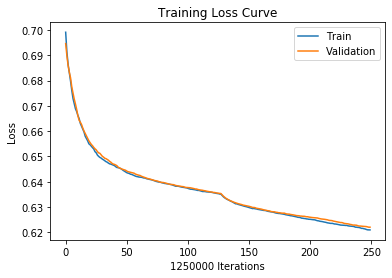

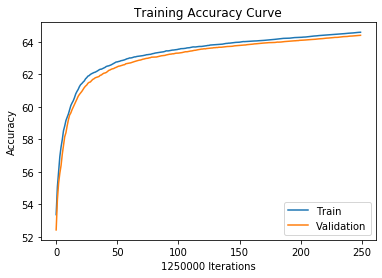

Training Accuracy at epoch 1: 64.58736
Validation Accuracy epoch 1: 64.39912


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


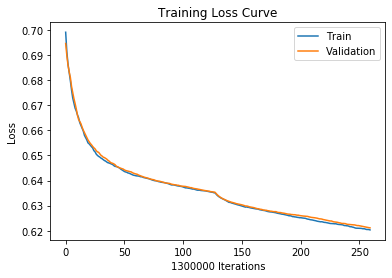

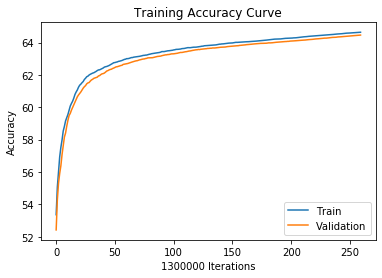

Training Accuracy at epoch 1: 64.63576923076923
Validation Accuracy epoch 1: 64.4603076923077


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


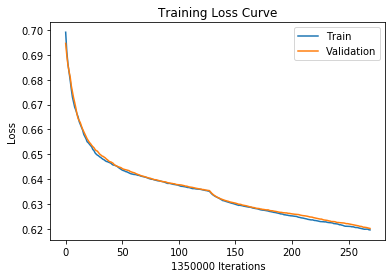

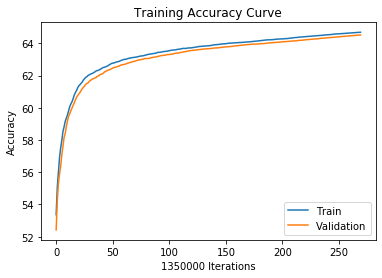

Training Accuracy at epoch 1: 64.68614814814815
Validation Accuracy epoch 1: 64.51659259259259


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


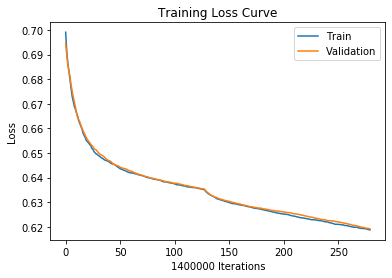

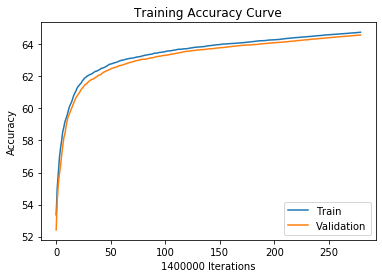

Training Accuracy at epoch 1: 64.74564285714285
Validation Accuracy epoch 1: 64.571


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


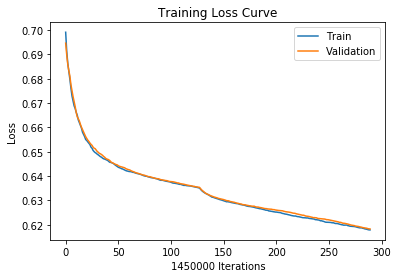

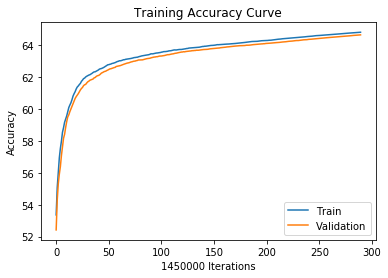

Training Accuracy at epoch 1: 64.79020689655172
Validation Accuracy epoch 1: 64.62565517241379


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


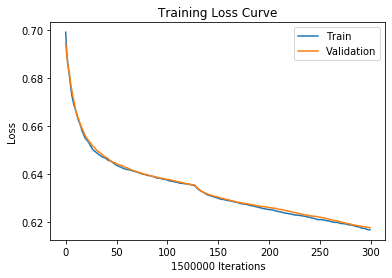

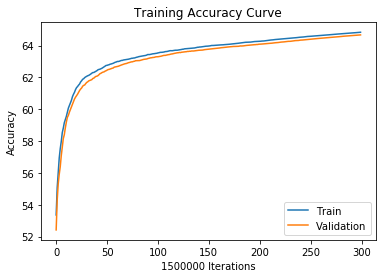

Training Accuracy at epoch 1: 64.84213333333334
Validation Accuracy epoch 1: 64.67466666666667


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


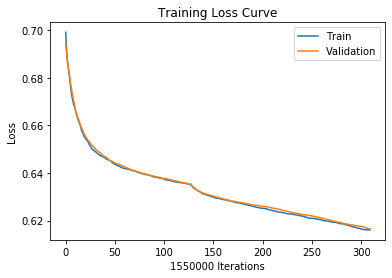

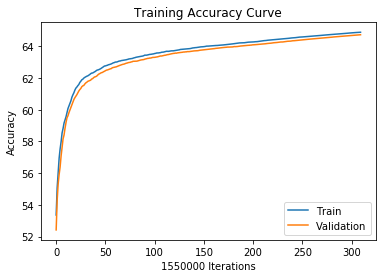

Training Accuracy at epoch 1: 64.88535483870967
Validation Accuracy epoch 1: 64.72741935483872


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


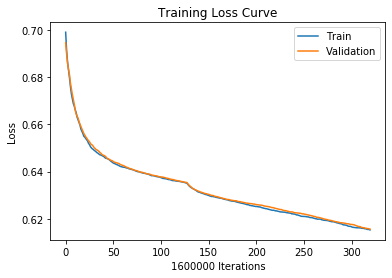

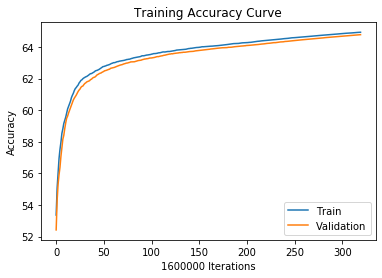

Training Accuracy at epoch 1: 64.930375
Validation Accuracy epoch 1: 64.7766875


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


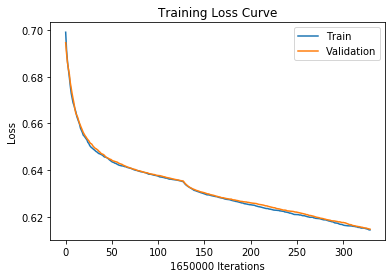

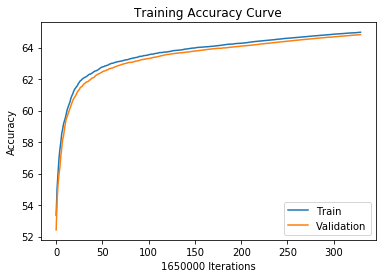

Training Accuracy at epoch 1: 64.97248484848485
Validation Accuracy epoch 1: 64.82036363636364


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


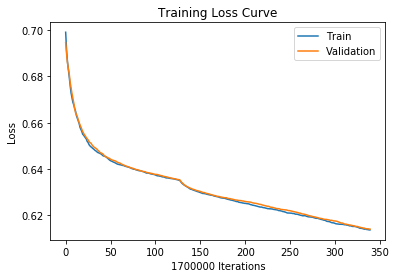

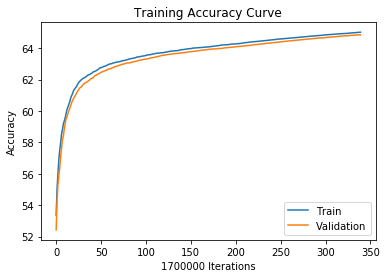

Training Accuracy at epoch 1: 65.01670588235294
Validation Accuracy epoch 1: 64.85688235294117


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


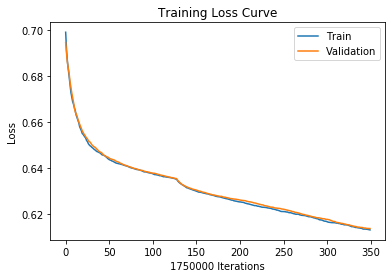

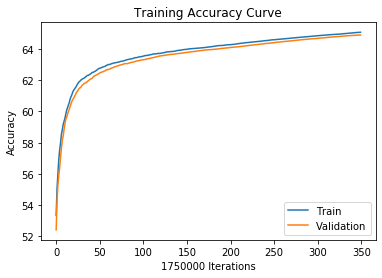

Training Accuracy at epoch 1: 65.06754285714285
Validation Accuracy epoch 1: 64.89485714285715


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


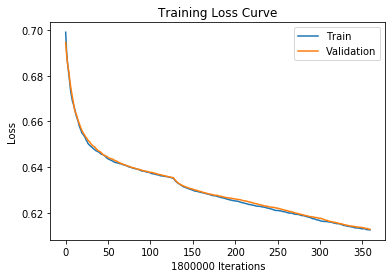

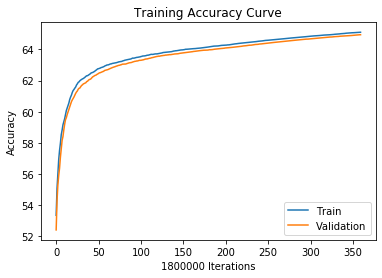

Training Accuracy at epoch 1: 65.10144444444444
Validation Accuracy epoch 1: 64.94205555555556


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


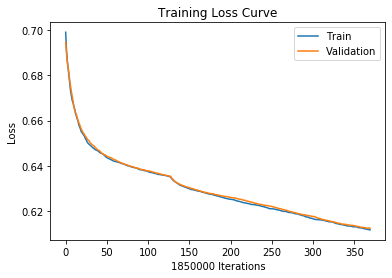

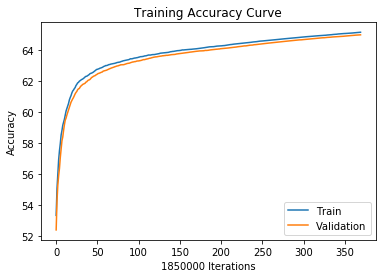

Training Accuracy at epoch 1: 65.15081081081081
Validation Accuracy epoch 1: 64.984


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 2  with learning rate:  [0.08100000000000002]


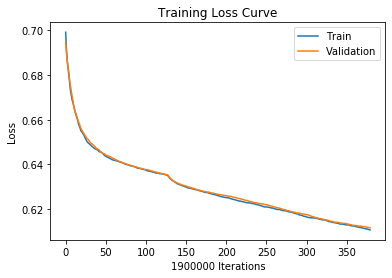

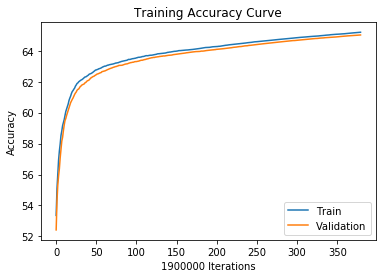

Training Accuracy at epoch 2: 65.19805263157895
Validation Accuracy epoch 2: 65.02142105263158


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


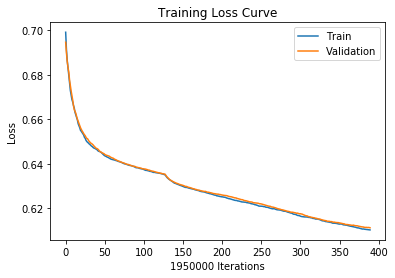

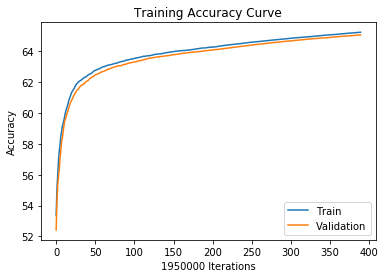

Training Accuracy at epoch 2: 65.23682051282051
Validation Accuracy epoch 2: 65.0637435897436


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


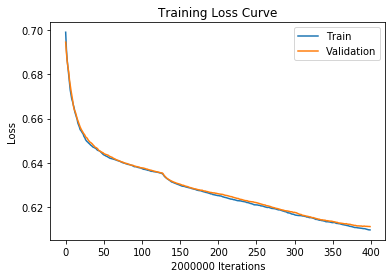

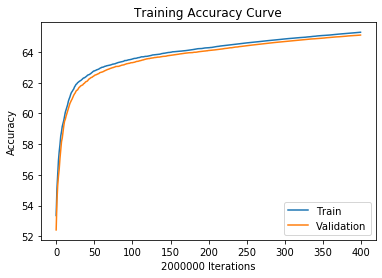

Training Accuracy at epoch 2: 65.2811
Validation Accuracy epoch 2: 65.0972


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


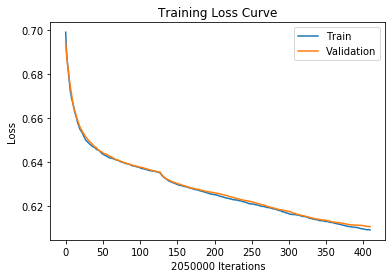

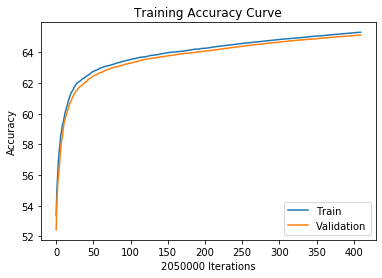

Training Accuracy at epoch 2: 65.32136585365853
Validation Accuracy epoch 2: 65.1399024390244


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


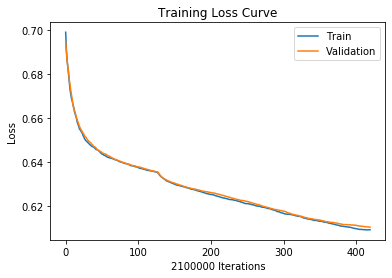

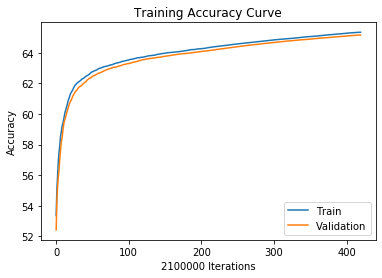

Training Accuracy at epoch 2: 65.34966666666666
Validation Accuracy epoch 2: 65.16942857142857


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


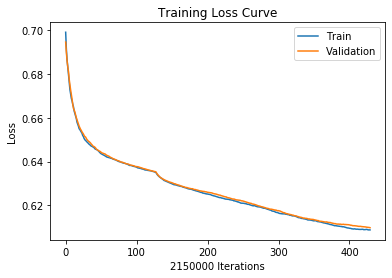

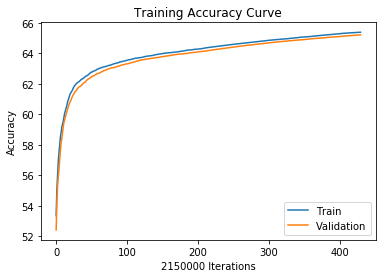

Training Accuracy at epoch 2: 65.37837209302326
Validation Accuracy epoch 2: 65.20520930232558


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


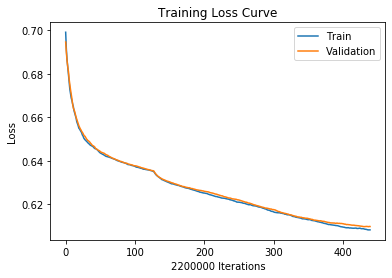

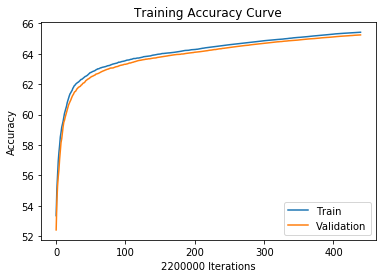

Training Accuracy at epoch 2: 65.40795454545454
Validation Accuracy epoch 2: 65.23209090909091


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


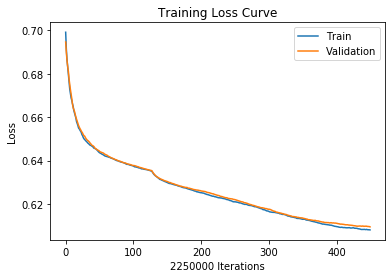

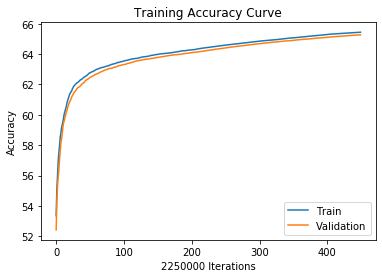

Training Accuracy at epoch 2: 65.43506666666667
Validation Accuracy epoch 2: 65.26822222222222


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


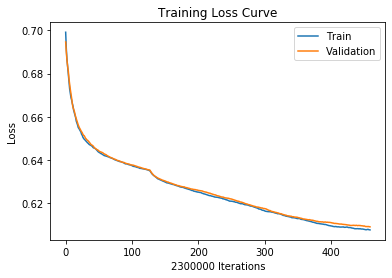

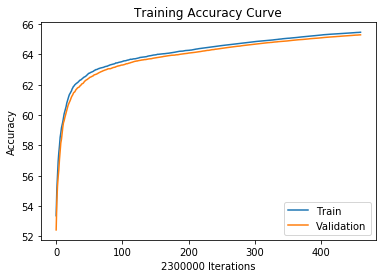

Training Accuracy at epoch 2: 65.46721739130435
Validation Accuracy epoch 2: 65.29595652173913


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


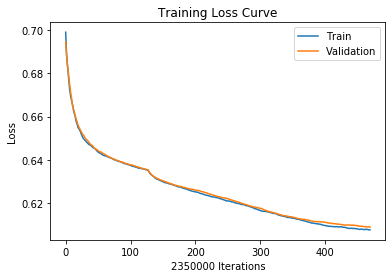

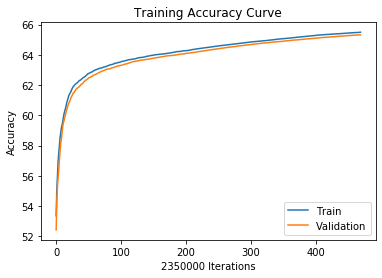

Training Accuracy at epoch 2: 65.49425531914893
Validation Accuracy epoch 2: 65.32263829787234


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


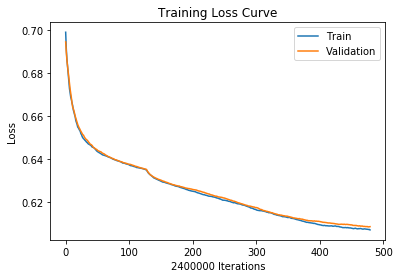

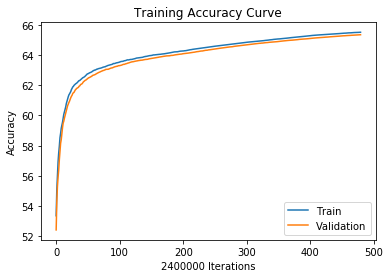

Training Accuracy at epoch 2: 65.51370833333333
Validation Accuracy epoch 2: 65.34875


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


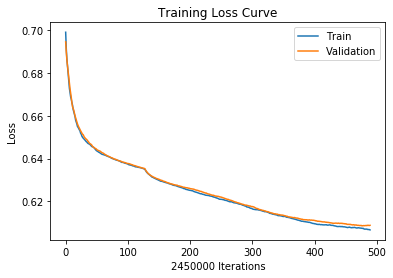

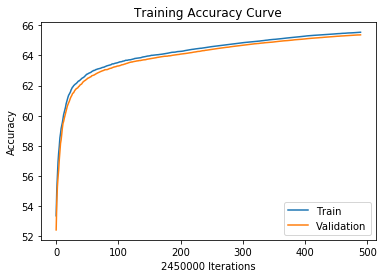

Training Accuracy at epoch 2: 65.54342857142858
Validation Accuracy epoch 2: 65.37044897959184


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


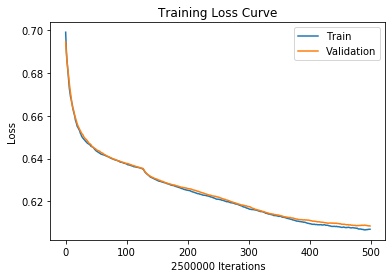

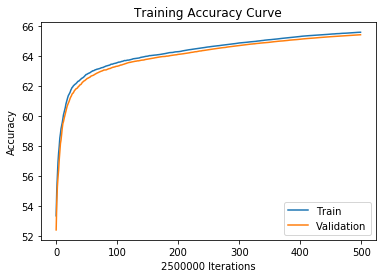

Training Accuracy at epoch 2: 65.56628
Validation Accuracy epoch 2: 65.39984


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


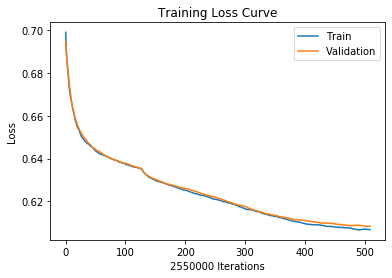

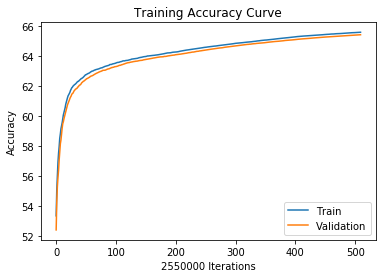

Training Accuracy at epoch 2: 65.59090196078431
Validation Accuracy epoch 2: 65.42435294117647


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


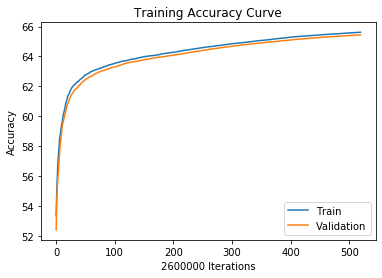

Training Accuracy at epoch 2: 65.61715384615384
Validation Accuracy epoch 2: 65.44142307692307


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


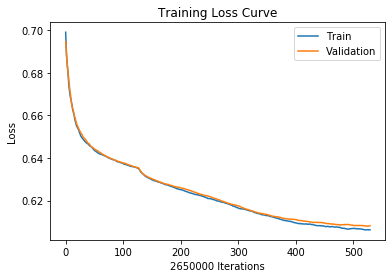

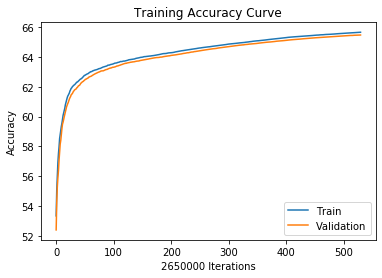

Training Accuracy at epoch 2: 65.64264150943396
Validation Accuracy epoch 2: 65.45724528301886


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


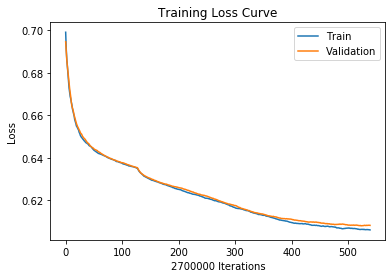

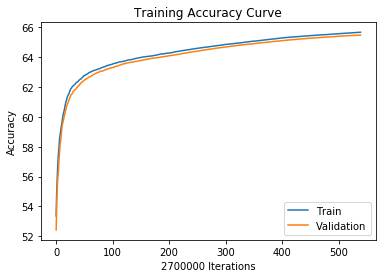

Training Accuracy at epoch 2: 65.66862962962963
Validation Accuracy epoch 2: 65.47759259259259


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


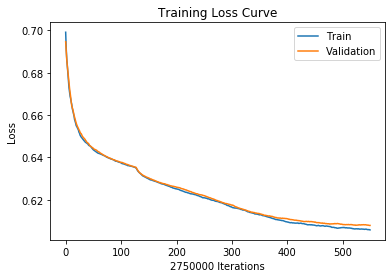

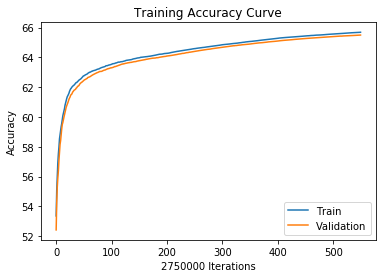

Training Accuracy at epoch 2: 65.68934545454546
Validation Accuracy epoch 2: 65.50018181818182


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


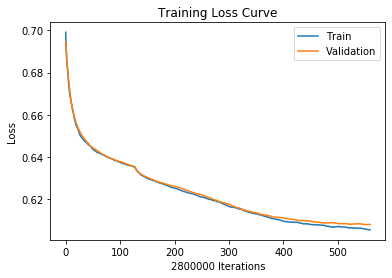

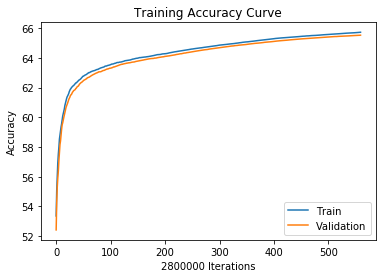

Training Accuracy at epoch 2: 65.71871428571428
Validation Accuracy epoch 2: 65.52067857142858


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 3  with learning rate:  [0.09000000000000001]


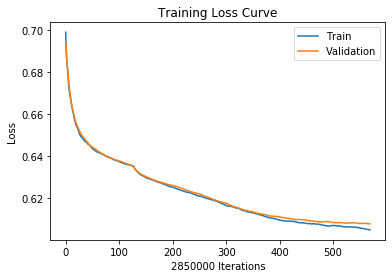

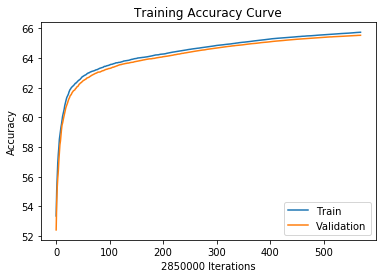

Training Accuracy at epoch 3: 65.74277192982456
Validation Accuracy epoch 3: 65.5380350877193


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


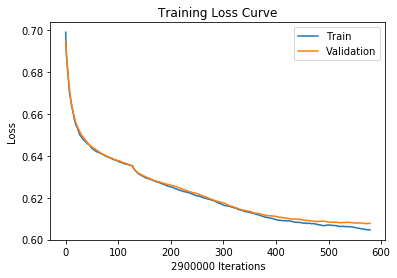

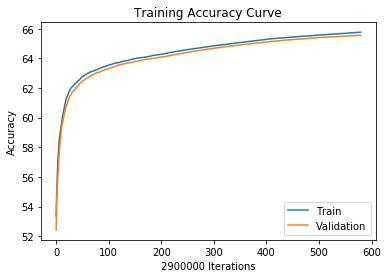

Training Accuracy at epoch 3: 65.76379310344828
Validation Accuracy epoch 3: 65.56110344827586


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


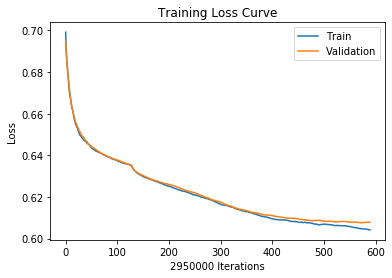

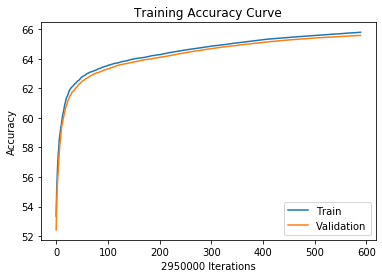

Training Accuracy at epoch 3: 65.79122033898305
Validation Accuracy epoch 3: 65.57959322033898


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


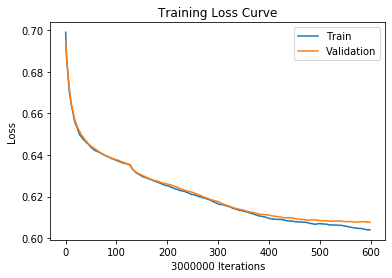

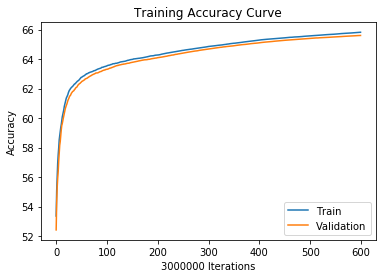

Training Accuracy at epoch 3: 65.8157
Validation Accuracy epoch 3: 65.59806666666667


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


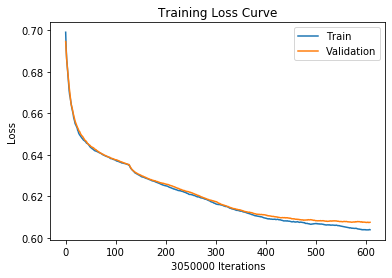

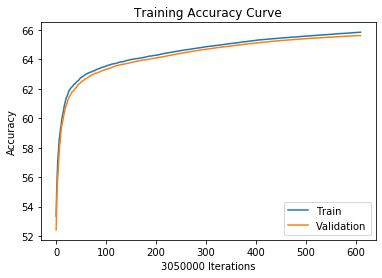

Training Accuracy at epoch 3: 65.83301639344262
Validation Accuracy epoch 3: 65.61003278688524


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


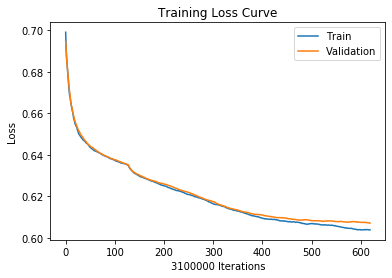

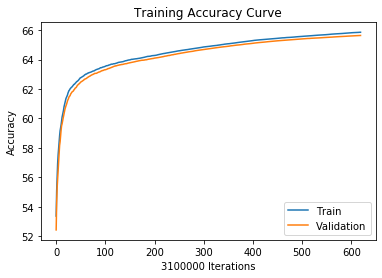

Training Accuracy at epoch 3: 65.85241935483872
Validation Accuracy epoch 3: 65.63374193548387


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


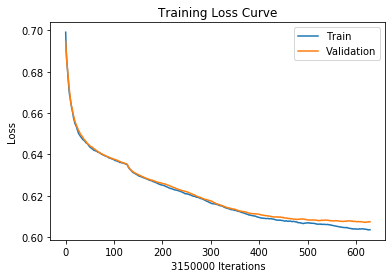

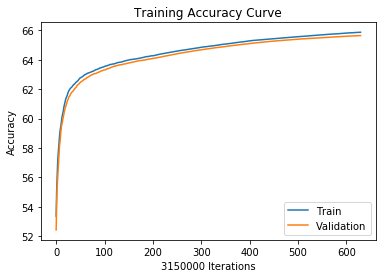

Training Accuracy at epoch 3: 65.87177777777778
Validation Accuracy epoch 3: 65.64580952380952


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


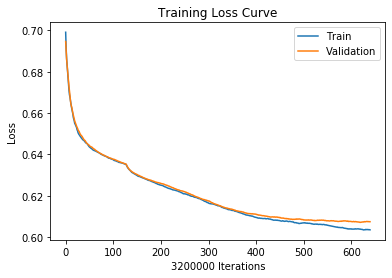

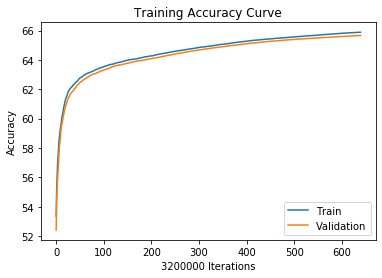

Training Accuracy at epoch 3: 65.88728125
Validation Accuracy epoch 3: 65.66509375


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


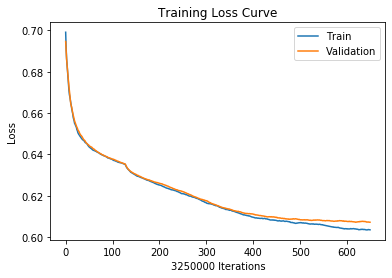

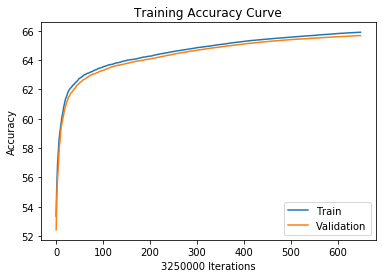

Training Accuracy at epoch 3: 65.90630769230769
Validation Accuracy epoch 3: 65.68166153846154


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


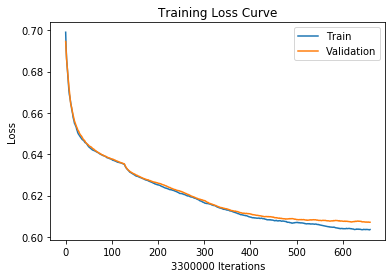

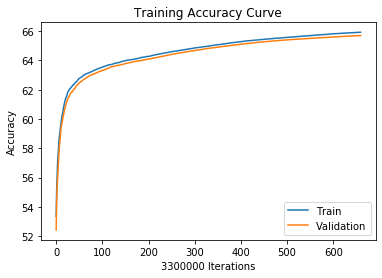

Training Accuracy at epoch 3: 65.92269696969697
Validation Accuracy epoch 3: 65.69848484848485


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


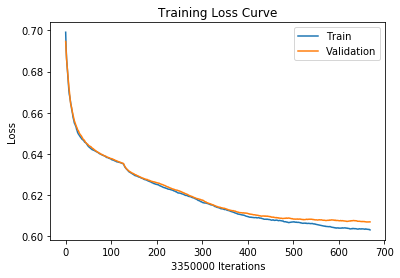

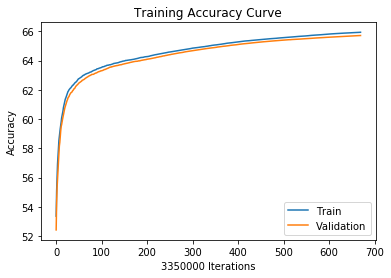

Training Accuracy at epoch 3: 65.9390447761194
Validation Accuracy epoch 3: 65.71579104477613


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


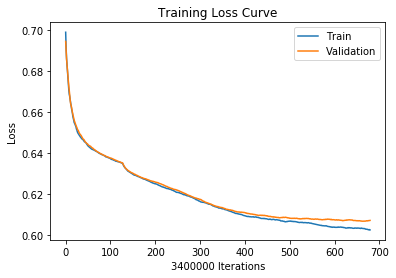

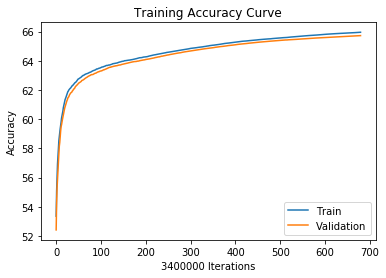

Training Accuracy at epoch 3: 65.9585294117647
Validation Accuracy epoch 3: 65.72738235294118


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


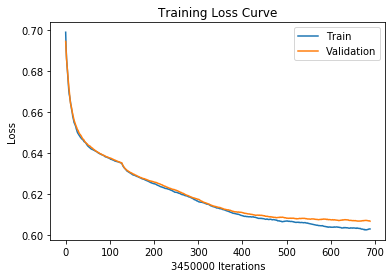

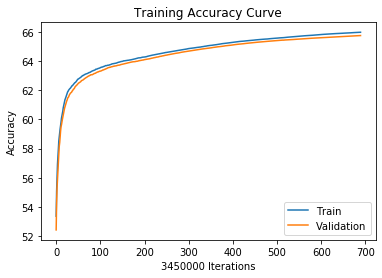

Training Accuracy at epoch 3: 65.97136231884058
Validation Accuracy epoch 3: 65.74426086956522


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


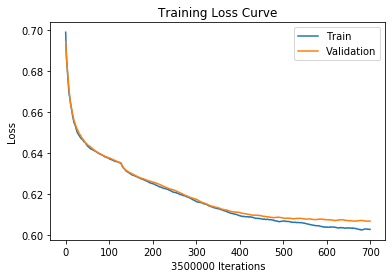

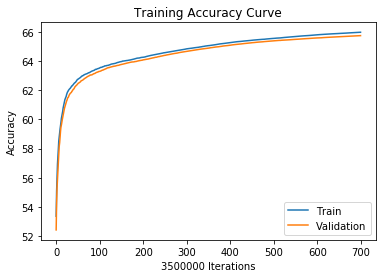

Training Accuracy at epoch 3: 65.98977142857143
Validation Accuracy epoch 3: 65.75705714285715


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


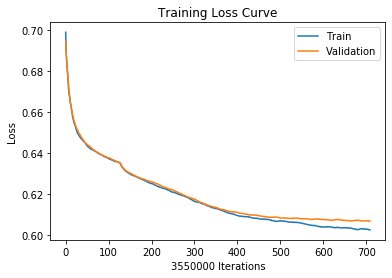

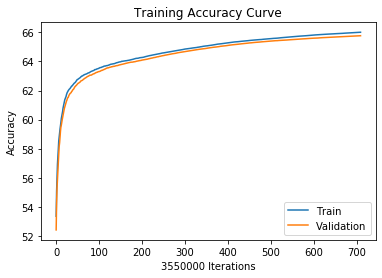

Training Accuracy at epoch 3: 66.0081690140845
Validation Accuracy epoch 3: 65.76839436619719


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


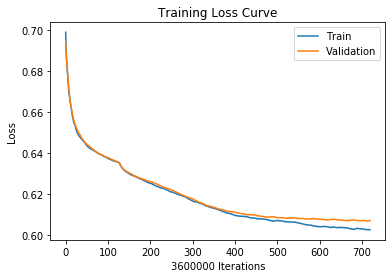

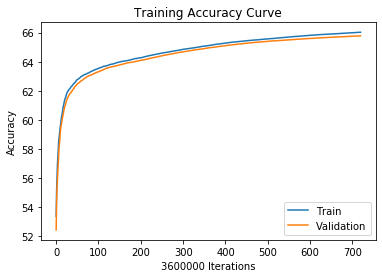

Training Accuracy at epoch 3: 66.02630555555555
Validation Accuracy epoch 3: 65.7803611111111


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


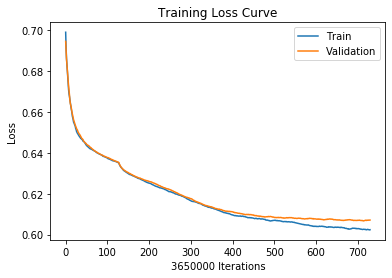

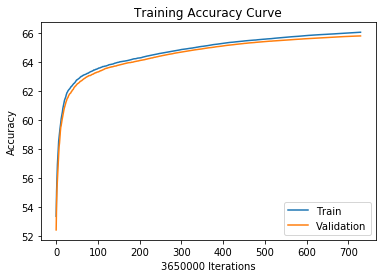

Training Accuracy at epoch 3: 66.04383561643836
Validation Accuracy epoch 3: 65.7895890410959


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


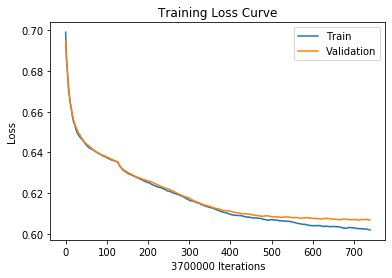

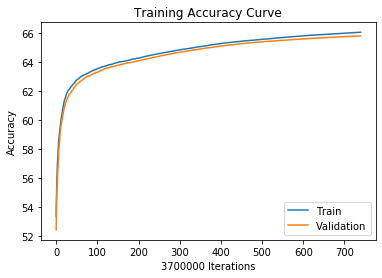

Training Accuracy at epoch 3: 66.06051351351351
Validation Accuracy epoch 3: 65.8057027027027


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


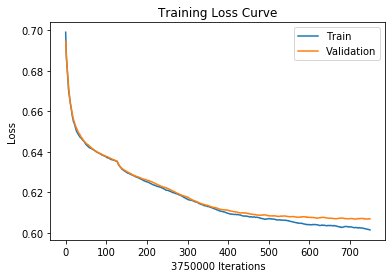

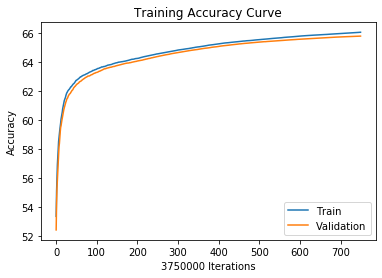

Training Accuracy at epoch 3: 66.08144
Validation Accuracy epoch 3: 65.81405333333333


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 4  with learning rate:  [0.09000000000000001]


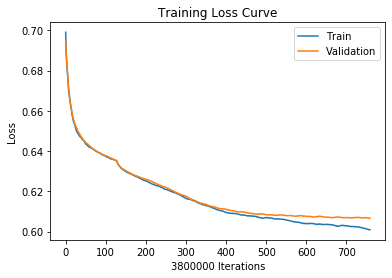

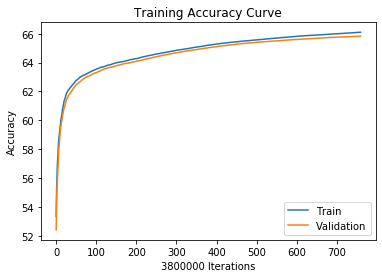

Training Accuracy at epoch 4: 66.09836842105263
Validation Accuracy epoch 4: 65.82668421052631


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


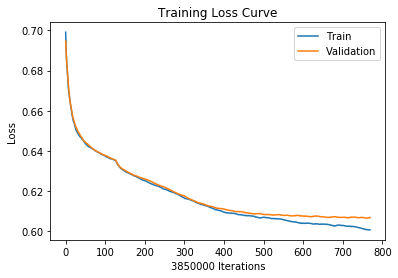

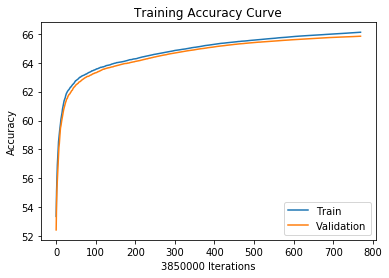

Training Accuracy at epoch 4: 66.11441558441558
Validation Accuracy epoch 4: 65.83890909090908


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


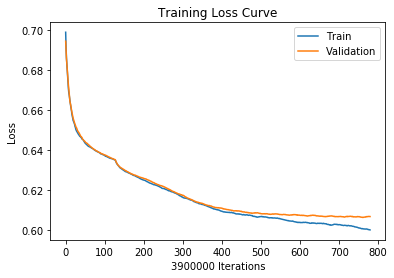

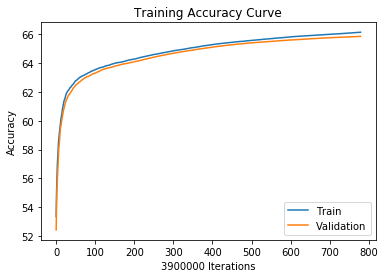

Training Accuracy at epoch 4: 66.13776923076924
Validation Accuracy epoch 4: 65.85164102564103


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


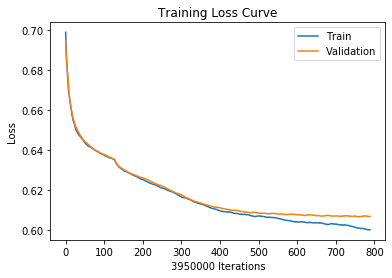

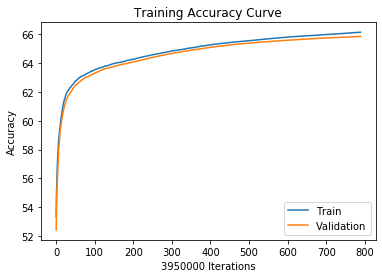

Training Accuracy at epoch 4: 66.15453164556962
Validation Accuracy epoch 4: 65.86473417721518


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


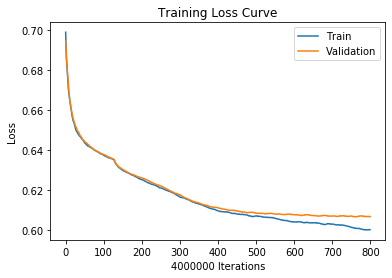

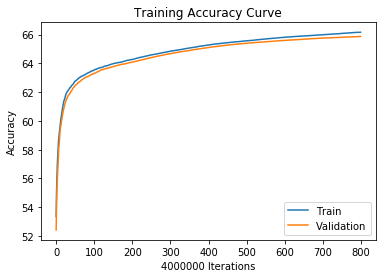

Training Accuracy at epoch 4: 66.165975
Validation Accuracy epoch 4: 65.8715


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


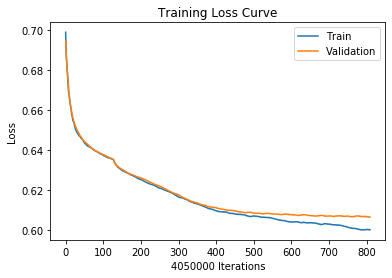

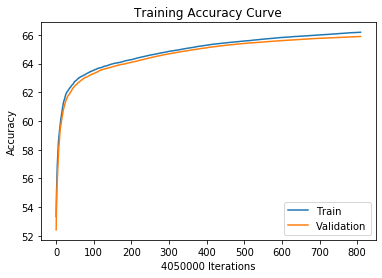

Training Accuracy at epoch 4: 66.18128395061728
Validation Accuracy epoch 4: 65.88558024691358


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


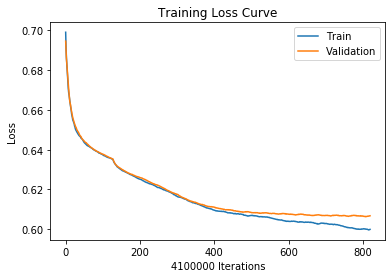

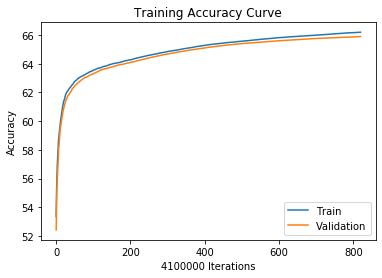

Training Accuracy at epoch 4: 66.19373170731707
Validation Accuracy epoch 4: 65.89329268292683


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


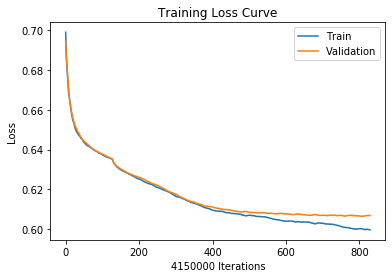

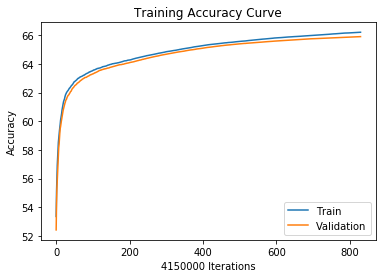

Training Accuracy at epoch 4: 66.21002409638554
Validation Accuracy epoch 4: 65.90438554216867


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


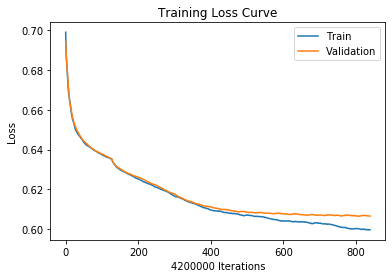

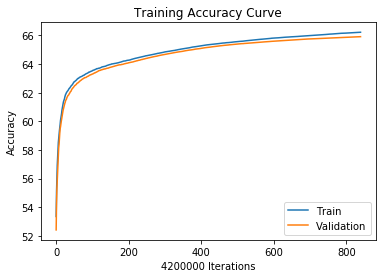

Training Accuracy at epoch 4: 66.22480952380953
Validation Accuracy epoch 4: 65.91538095238096


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


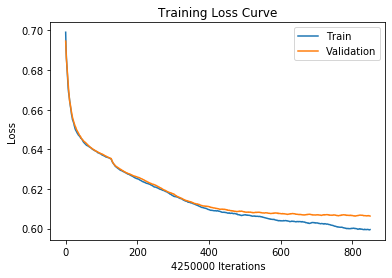

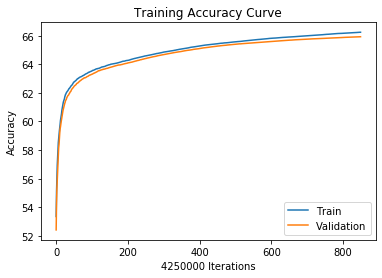

Training Accuracy at epoch 4: 66.2396705882353
Validation Accuracy epoch 4: 65.92569411764705


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


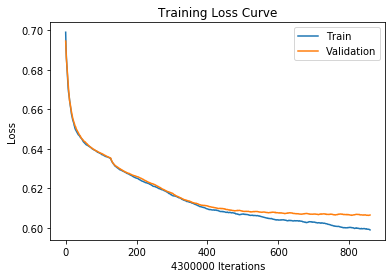

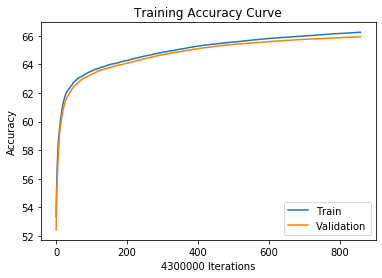

Training Accuracy at epoch 4: 66.25518604651162
Validation Accuracy epoch 4: 65.93323255813954


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


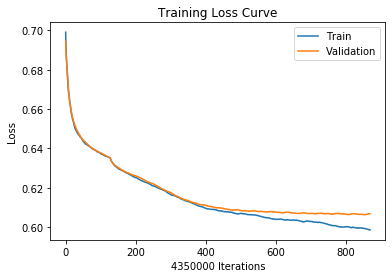

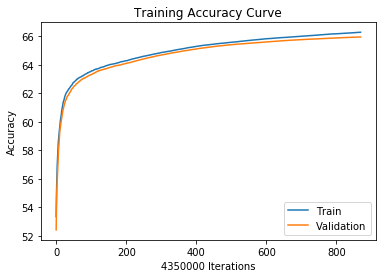

Training Accuracy at epoch 4: 66.27425287356321
Validation Accuracy epoch 4: 65.9400459770115


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


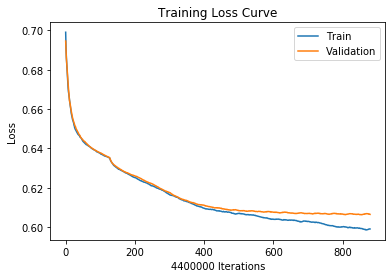

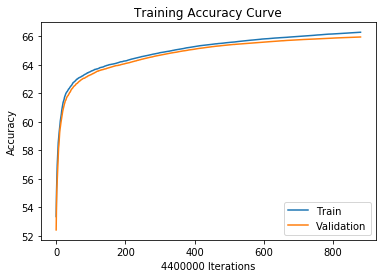

Training Accuracy at epoch 4: 66.28588636363637
Validation Accuracy epoch 4: 65.95247727272728


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


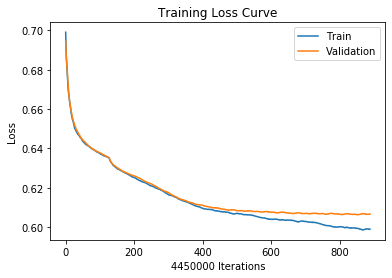

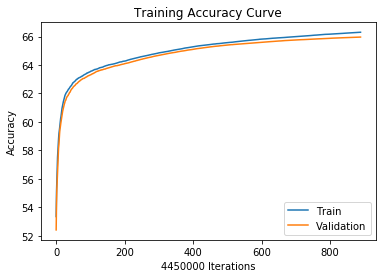

Training Accuracy at epoch 4: 66.30022471910112
Validation Accuracy epoch 4: 65.96060674157303


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


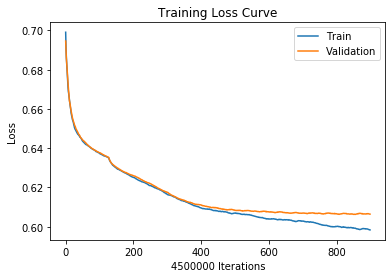

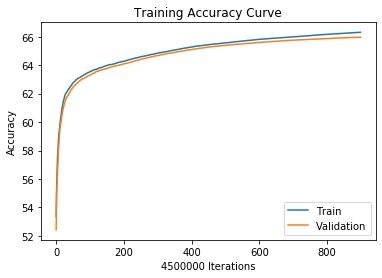

Training Accuracy at epoch 4: 66.31662222222222
Validation Accuracy epoch 4: 65.9688


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


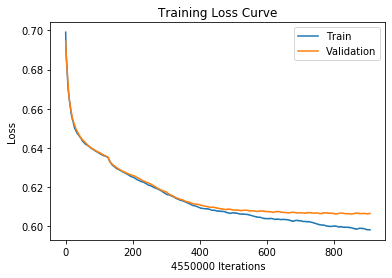

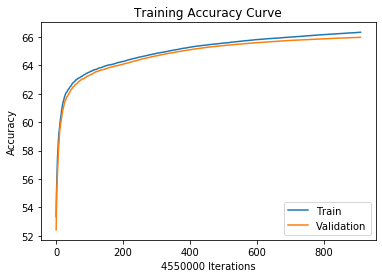

Training Accuracy at epoch 4: 66.33378021978022
Validation Accuracy epoch 4: 65.97591208791209


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


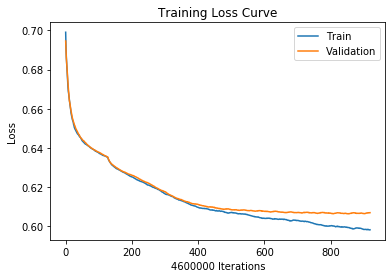

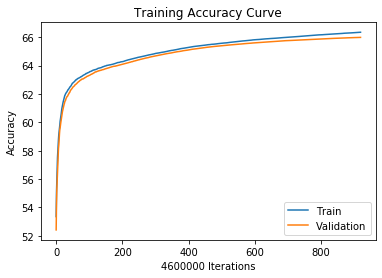

Training Accuracy at epoch 4: 66.34608695652175
Validation Accuracy epoch 4: 65.98378260869565


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


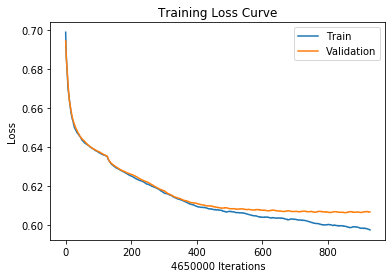

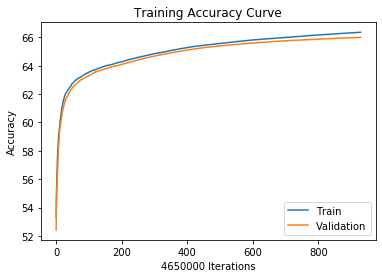

Training Accuracy at epoch 4: 66.3607311827957
Validation Accuracy epoch 4: 65.99496774193548


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


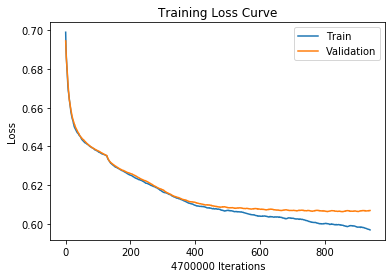

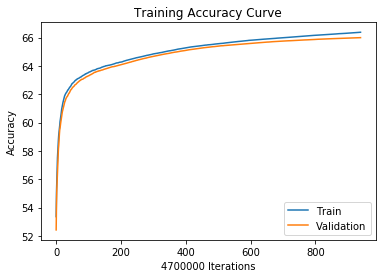

Training Accuracy at epoch 4: 66.38121276595744
Validation Accuracy epoch 4: 65.9992340425532


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 5  with learning rate:  [0.07290000000000002]


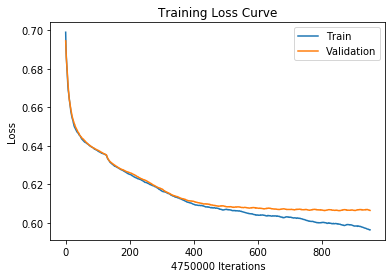

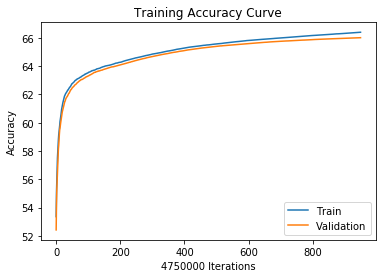

Training Accuracy at epoch 5: 66.39637894736842
Validation Accuracy epoch 5: 66.01054736842106


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


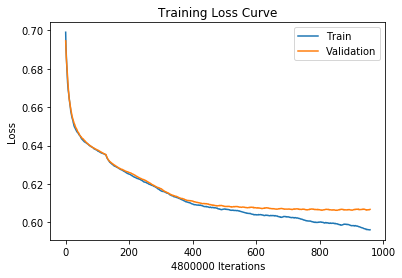

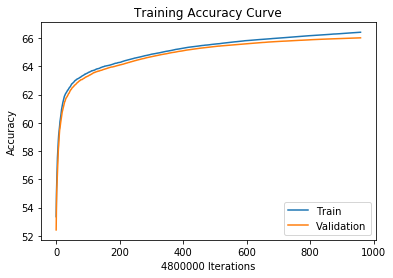

Training Accuracy at epoch 5: 66.40916666666666
Validation Accuracy epoch 5: 66.01354166666667


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


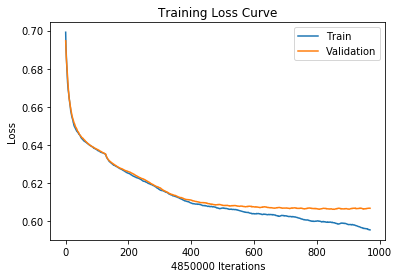

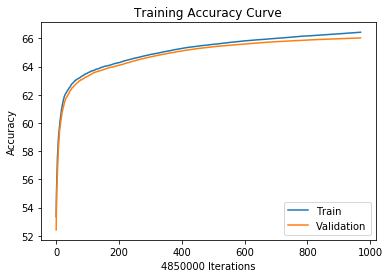

Training Accuracy at epoch 5: 66.4281855670103
Validation Accuracy epoch 5: 66.02377319587629


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


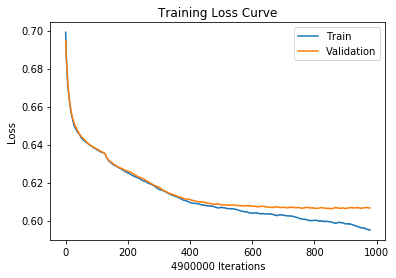

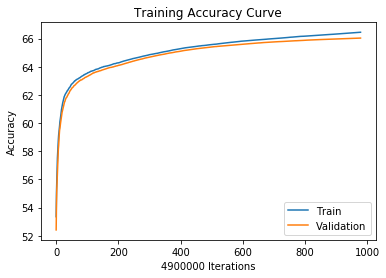

Training Accuracy at epoch 5: 66.445
Validation Accuracy epoch 5: 66.03077551020408


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


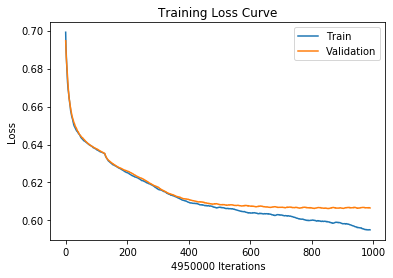

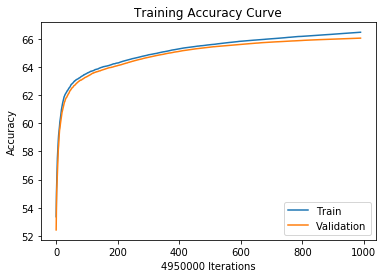

Training Accuracy at epoch 5: 66.45664646464647
Validation Accuracy epoch 5: 66.03818181818181


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


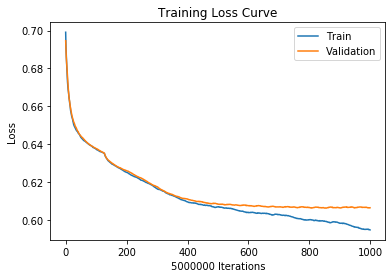

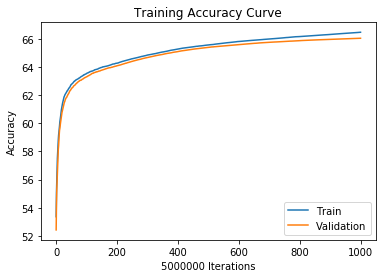

Training Accuracy at epoch 5: 66.4726
Validation Accuracy epoch 5: 66.04516


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


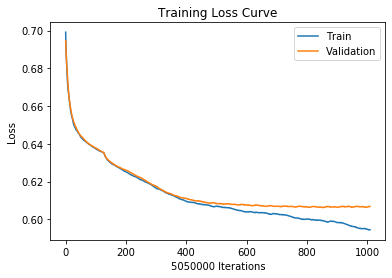

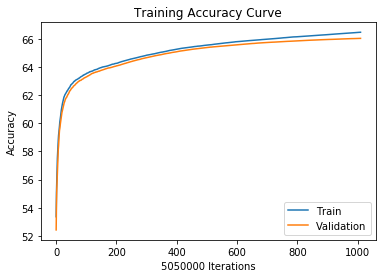

Training Accuracy at epoch 5: 66.4860594059406
Validation Accuracy epoch 5: 66.05035643564356


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


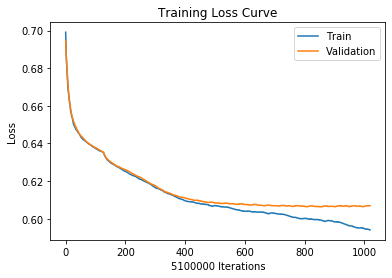

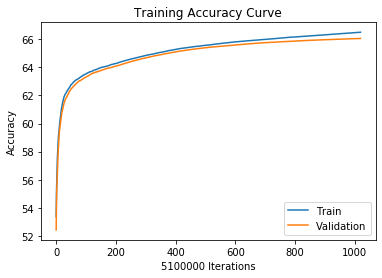

Training Accuracy at epoch 5: 66.50158823529412
Validation Accuracy epoch 5: 66.05650980392157


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


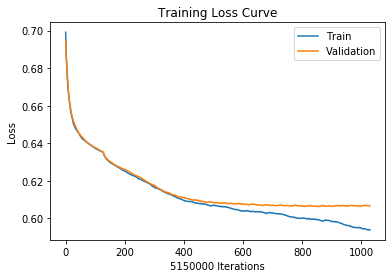

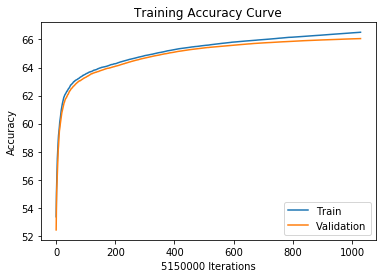

Training Accuracy at epoch 5: 66.51741747572815
Validation Accuracy epoch 5: 66.06448543689321


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


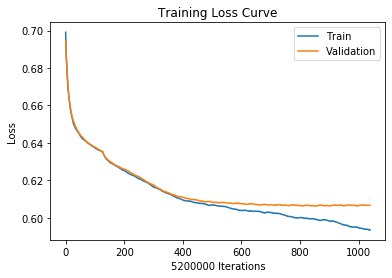

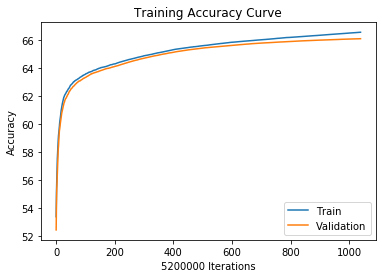

Training Accuracy at epoch 5: 66.53205769230769
Validation Accuracy epoch 5: 66.07076923076923


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


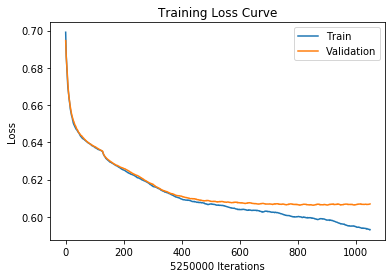

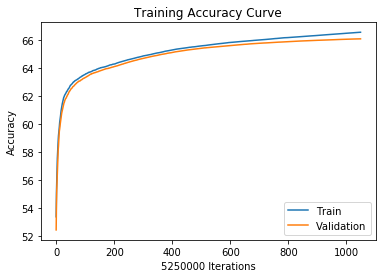

Training Accuracy at epoch 5: 66.54592380952381
Validation Accuracy epoch 5: 66.0739238095238


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


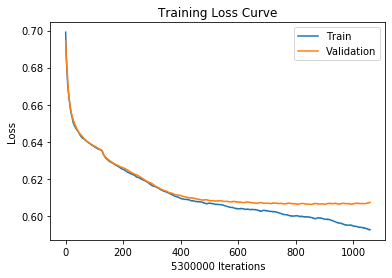

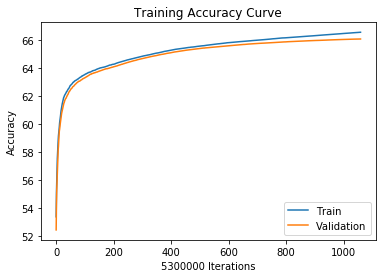

Training Accuracy at epoch 5: 66.56167924528302
Validation Accuracy epoch 5: 66.0784716981132


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


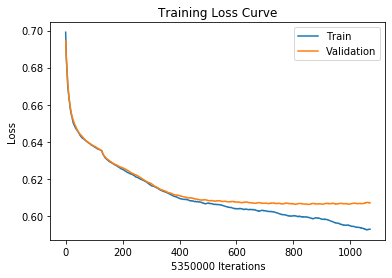

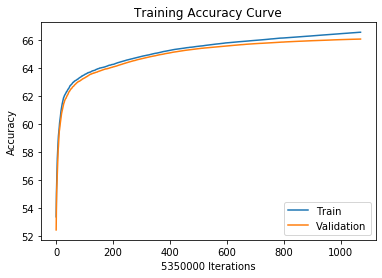

Training Accuracy at epoch 5: 66.57444859813084
Validation Accuracy epoch 5: 66.08581308411215


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


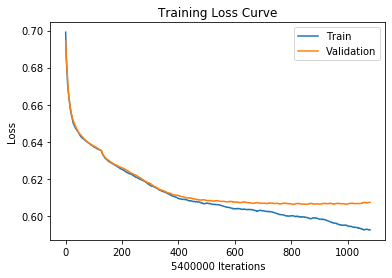

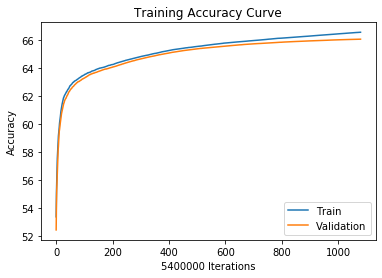

Training Accuracy at epoch 5: 66.58846296296296
Validation Accuracy epoch 5: 66.091


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


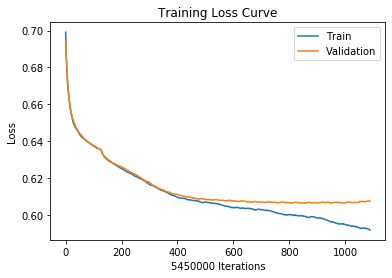

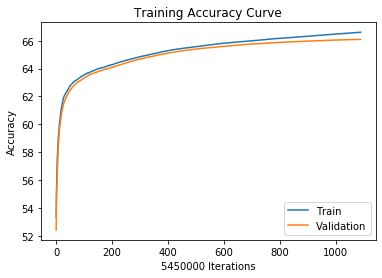

Training Accuracy at epoch 5: 66.60548623853211
Validation Accuracy epoch 5: 66.09326605504587


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


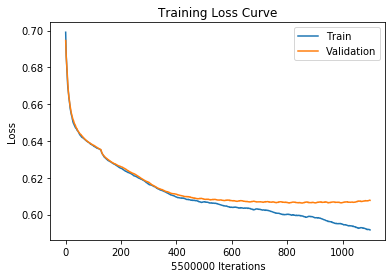

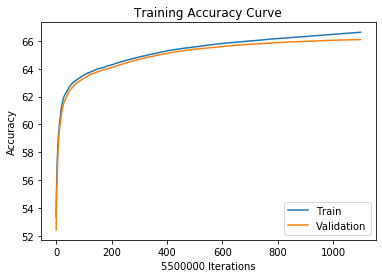

Training Accuracy at epoch 5: 66.62234545454545
Validation Accuracy epoch 5: 66.0961090909091


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


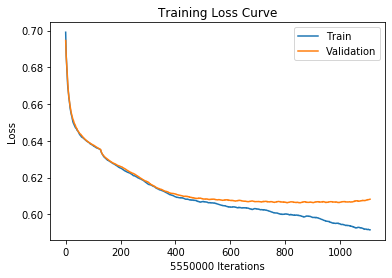

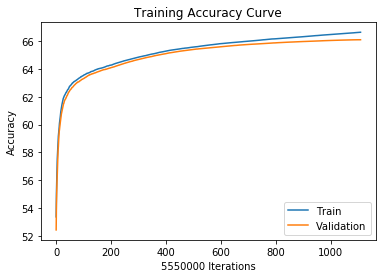

Training Accuracy at epoch 5: 66.63673873873874
Validation Accuracy epoch 5: 66.09693693693694


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


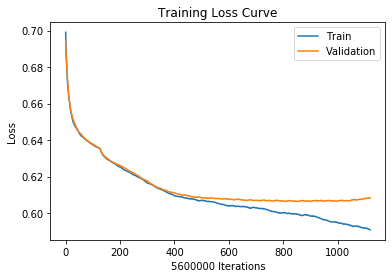

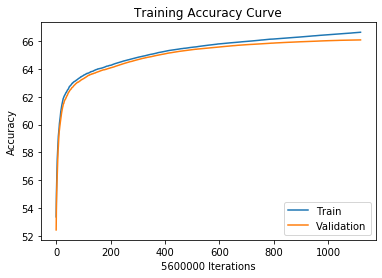

Training Accuracy at epoch 5: 66.65375
Validation Accuracy epoch 5: 66.10157142857143


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


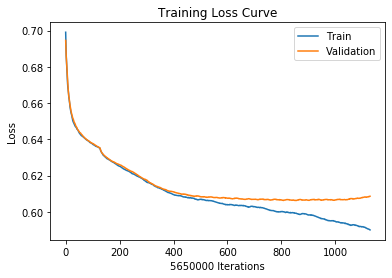

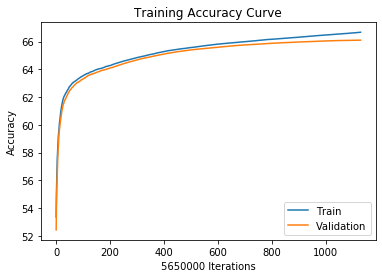

Training Accuracy at epoch 5: 66.67348672566372
Validation Accuracy epoch 5: 66.10249557522124


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 6  with learning rate:  [0.08100000000000002]


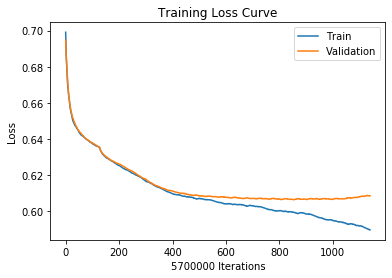

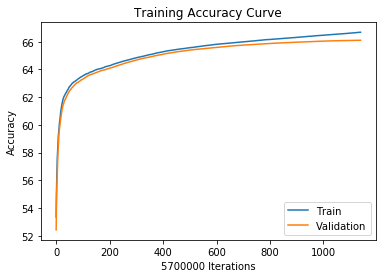

Training Accuracy at epoch 6: 66.68766666666667
Validation Accuracy epoch 6: 66.10954385964912


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


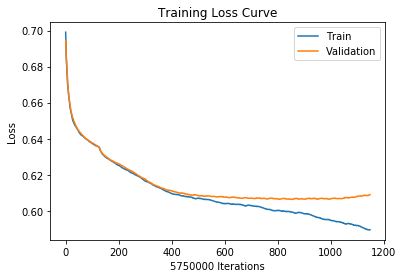

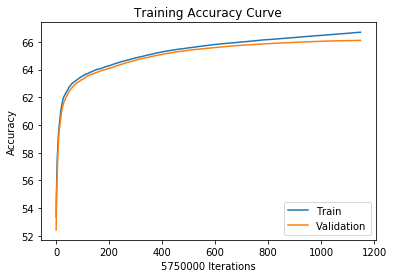

Training Accuracy at epoch 6: 66.69939130434783
Validation Accuracy epoch 6: 66.11139130434782


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


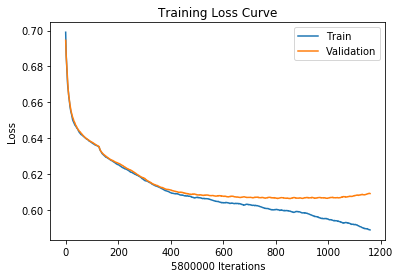

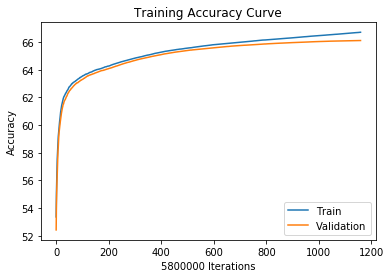

Training Accuracy at epoch 6: 66.71870689655172
Validation Accuracy epoch 6: 66.1198275862069


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


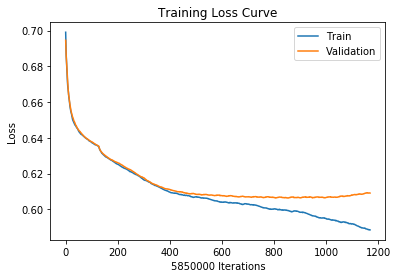

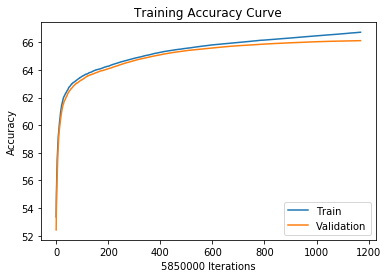

Training Accuracy at epoch 6: 66.73307692307692
Validation Accuracy epoch 6: 66.12389743589743


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


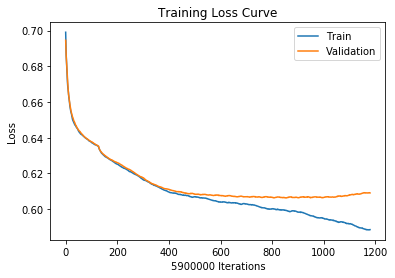

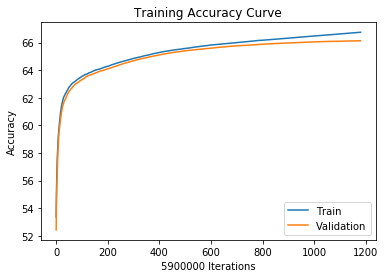

Training Accuracy at epoch 6: 66.74340677966102
Validation Accuracy epoch 6: 66.12603389830508


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


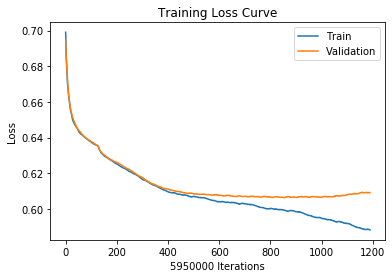

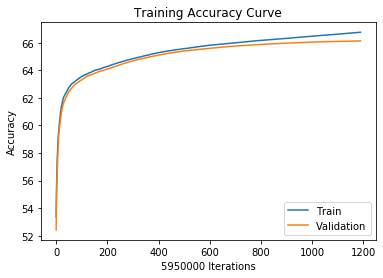

Training Accuracy at epoch 6: 66.7604705882353
Validation Accuracy epoch 6: 66.13060504201681


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


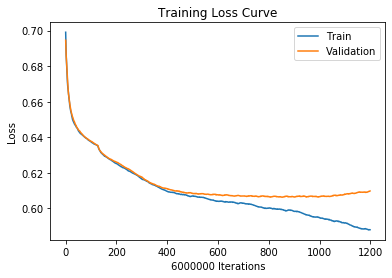

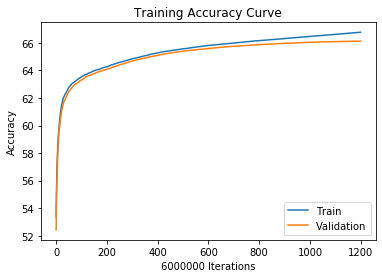

Training Accuracy at epoch 6: 66.77618333333334
Validation Accuracy epoch 6: 66.13345


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


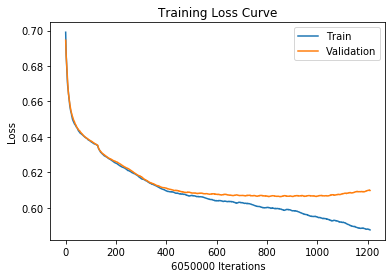

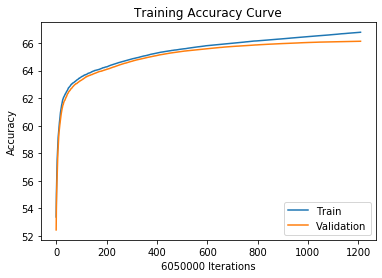

Training Accuracy at epoch 6: 66.79203305785124
Validation Accuracy epoch 6: 66.13704132231405


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


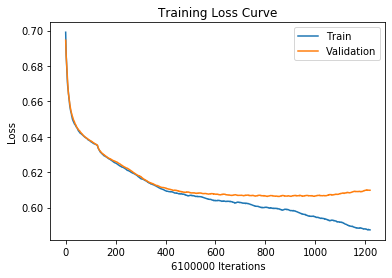

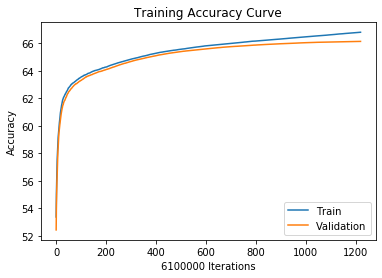

Training Accuracy at epoch 6: 66.80631147540984
Validation Accuracy epoch 6: 66.14022950819673


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


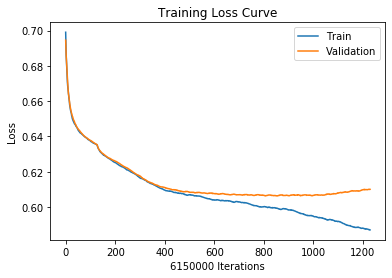

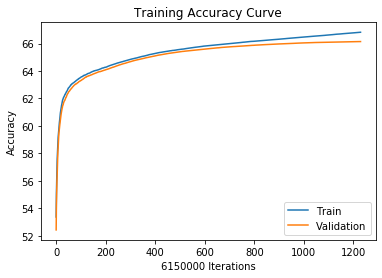

Training Accuracy at epoch 6: 66.82240650406504
Validation Accuracy epoch 6: 66.14325203252032


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


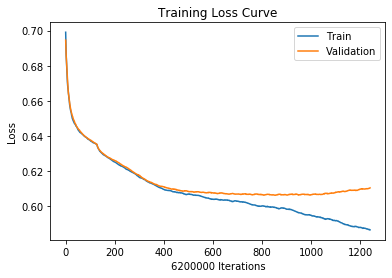

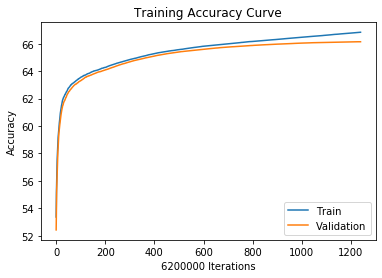

Training Accuracy at epoch 6: 66.8376129032258
Validation Accuracy epoch 6: 66.1438064516129


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


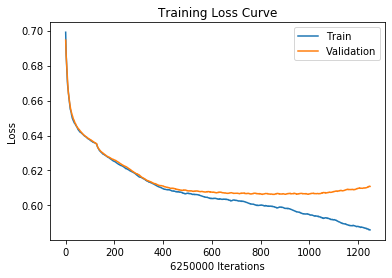

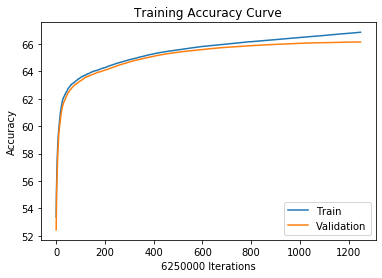

Training Accuracy at epoch 6: 66.856208
Validation Accuracy epoch 6: 66.144096


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


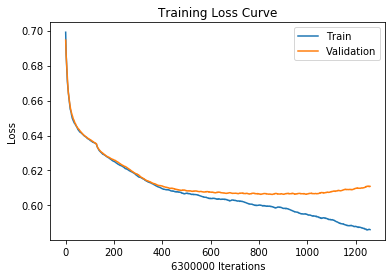

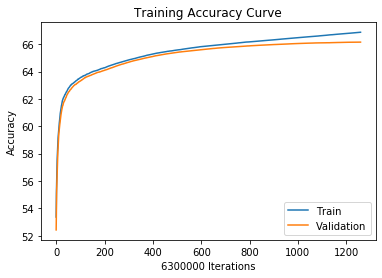

Training Accuracy at epoch 6: 66.87011111111111
Validation Accuracy epoch 6: 66.14719047619047


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


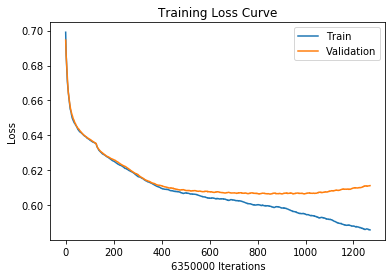

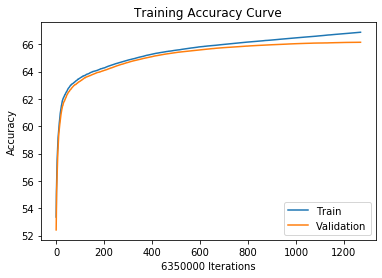

Training Accuracy at epoch 6: 66.8835748031496
Validation Accuracy epoch 6: 66.14981102362205


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


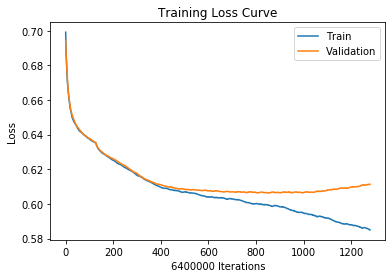

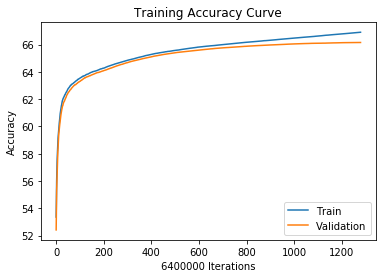

Training Accuracy at epoch 6: 66.901328125
Validation Accuracy epoch 6: 66.151140625


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


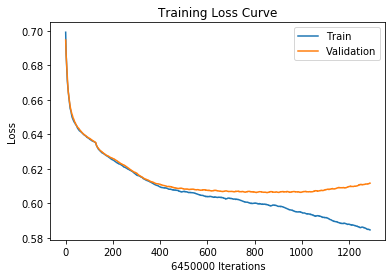

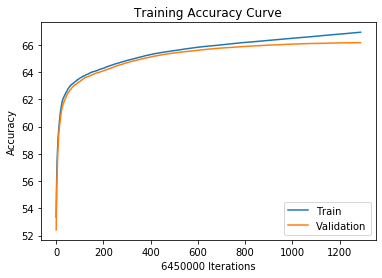

Training Accuracy at epoch 6: 66.91637209302326
Validation Accuracy epoch 6: 66.15162790697674


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


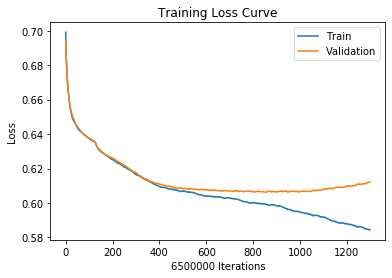

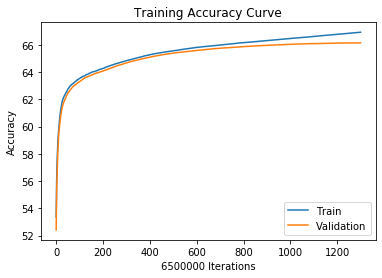

Training Accuracy at epoch 6: 66.93103076923077
Validation Accuracy epoch 6: 66.1521076923077


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


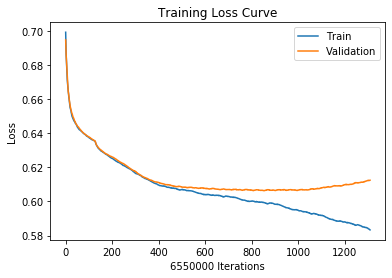

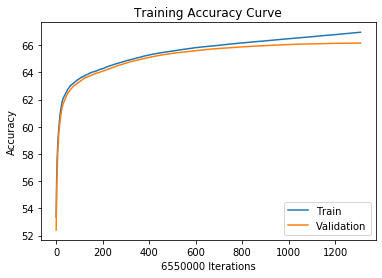

Training Accuracy at epoch 6: 66.9506717557252
Validation Accuracy epoch 6: 66.15473282442748


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


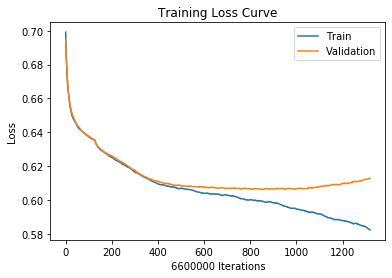

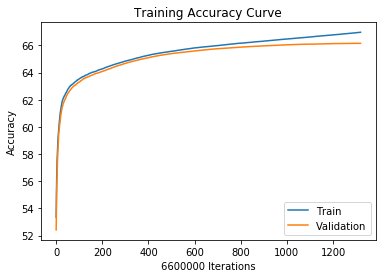

Training Accuracy at epoch 6: 66.97201515151515
Validation Accuracy epoch 6: 66.1534696969697


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 7  with learning rate:  [0.08100000000000002]


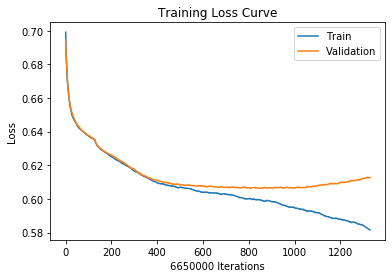

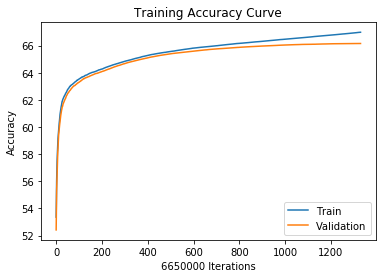

Training Accuracy at epoch 7: 66.98643609022557
Validation Accuracy epoch 7: 66.15747368421053


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


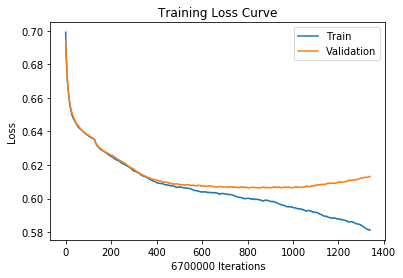

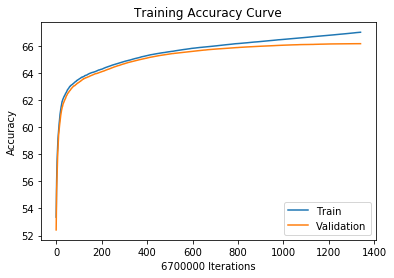

Training Accuracy at epoch 7: 67.00116417910448
Validation Accuracy epoch 7: 66.15711940298507


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


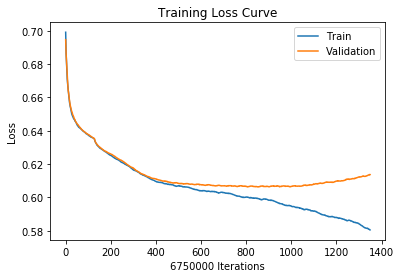

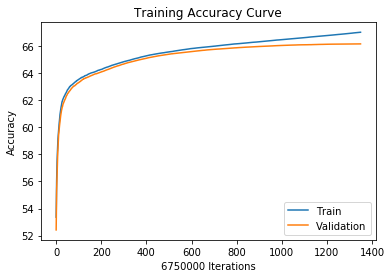

Training Accuracy at epoch 7: 67.02136296296297
Validation Accuracy epoch 7: 66.16051851851851


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


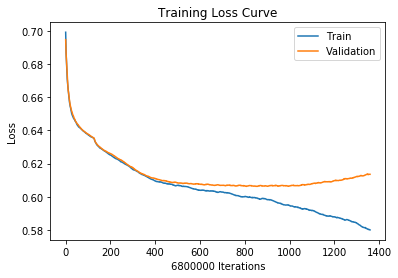

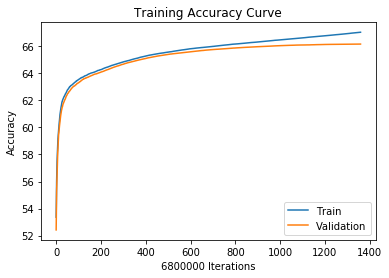

Training Accuracy at epoch 7: 67.0384705882353
Validation Accuracy epoch 7: 66.16316176470588


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


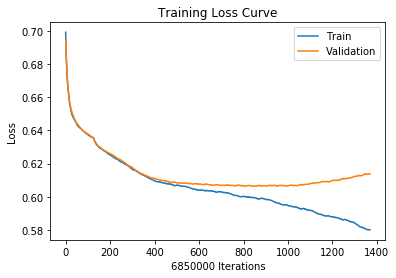

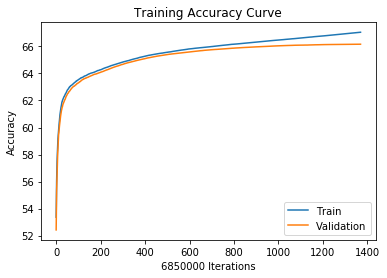

Training Accuracy at epoch 7: 67.05093430656935
Validation Accuracy epoch 7: 66.16528467153285


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


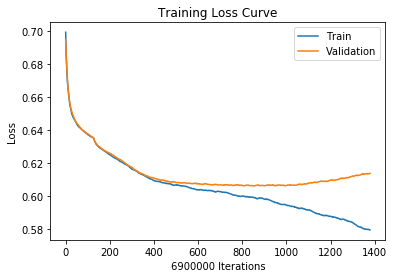

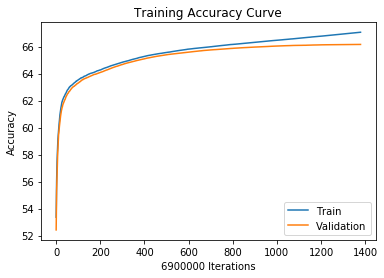

Training Accuracy at epoch 7: 67.06821739130434
Validation Accuracy epoch 7: 66.16534782608696


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


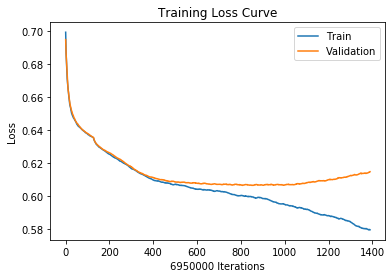

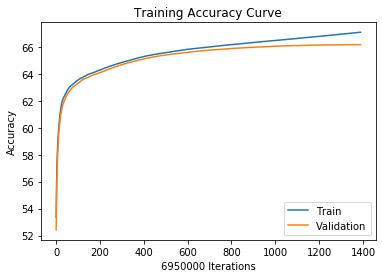

Training Accuracy at epoch 7: 67.08424460431655
Validation Accuracy epoch 7: 66.16589928057554


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


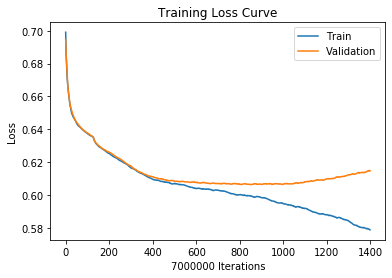

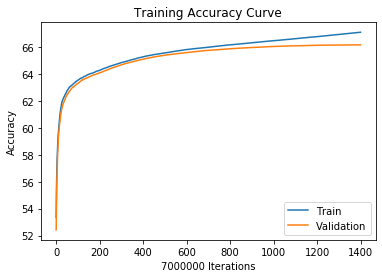

Training Accuracy at epoch 7: 67.10257142857142
Validation Accuracy epoch 7: 66.16697142857143


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


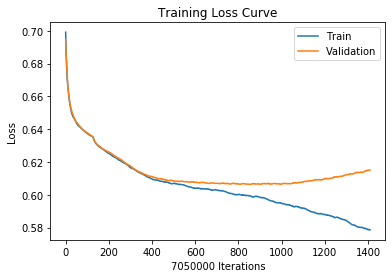

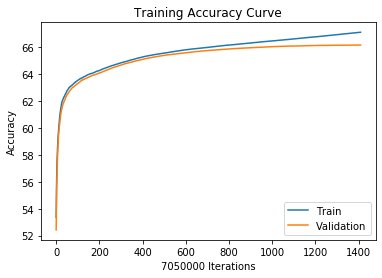

Training Accuracy at epoch 7: 67.12
Validation Accuracy epoch 7: 66.16775886524823


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


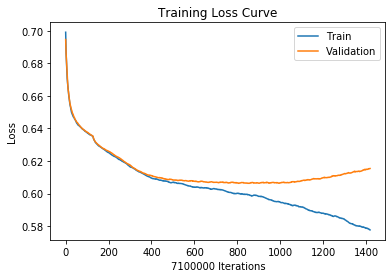

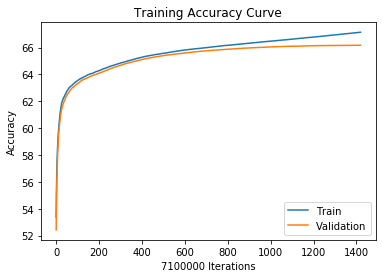

Training Accuracy at epoch 7: 67.13812676056338
Validation Accuracy epoch 7: 66.16804225352112


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


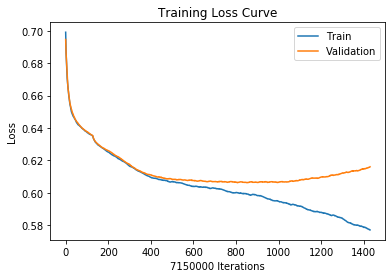

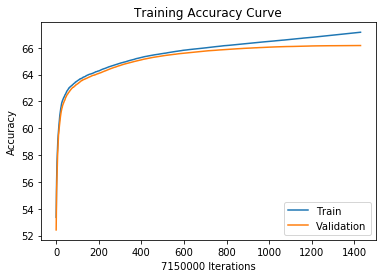

Training Accuracy at epoch 7: 67.15723076923076
Validation Accuracy epoch 7: 66.16616783216783


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


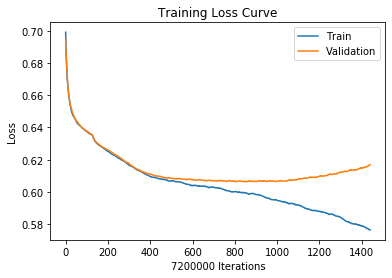

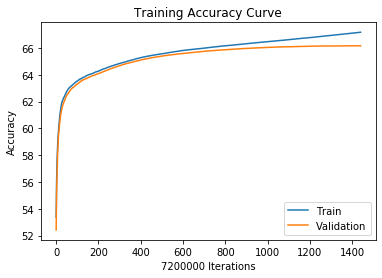

Training Accuracy at epoch 7: 67.17723611111111
Validation Accuracy epoch 7: 66.16481944444445


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


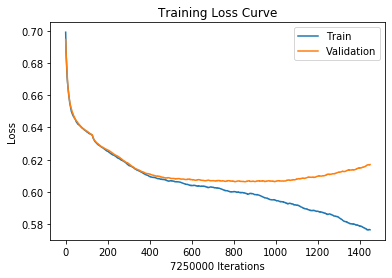

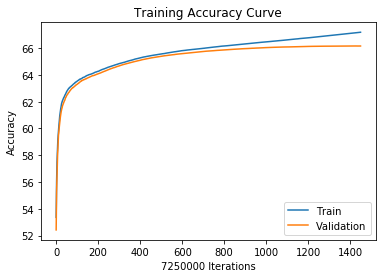

Training Accuracy at epoch 7: 67.19366896551725
Validation Accuracy epoch 7: 66.16492413793104


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


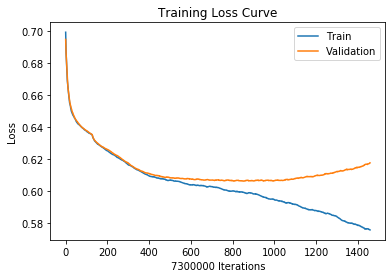

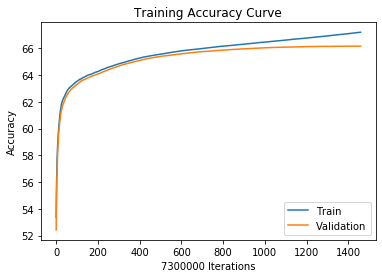

Training Accuracy at epoch 7: 67.21028767123288
Validation Accuracy epoch 7: 66.16289041095891


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


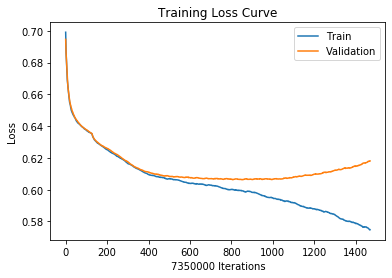

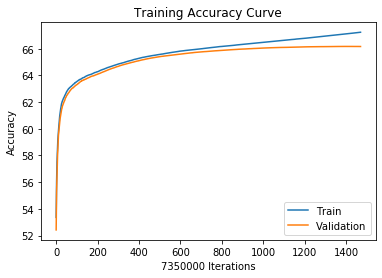

Training Accuracy at epoch 7: 67.23024489795918
Validation Accuracy epoch 7: 66.1616462585034


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


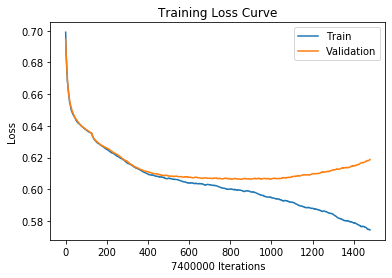

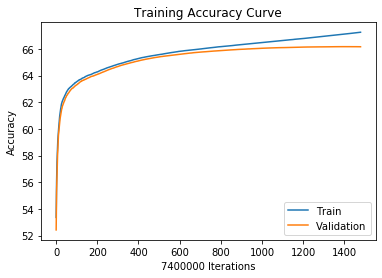

Training Accuracy at epoch 7: 67.2485
Validation Accuracy epoch 7: 66.15947297297298


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


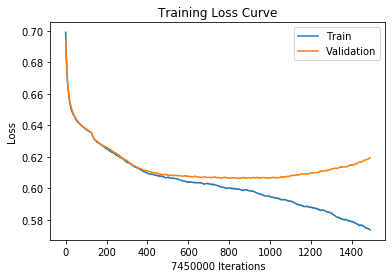

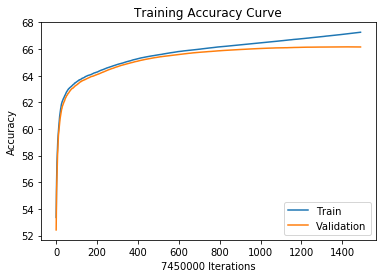

Training Accuracy at epoch 7: 67.26531543624161
Validation Accuracy epoch 7: 66.15930201342282


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


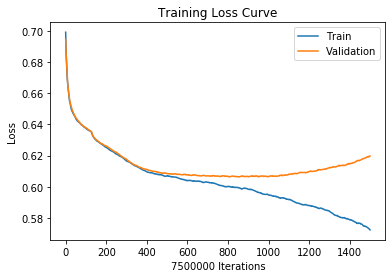

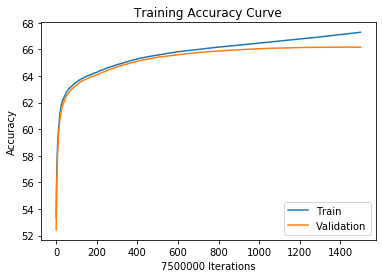

Training Accuracy at epoch 7: 67.28525333333333
Validation Accuracy epoch 7: 66.16025333333333


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


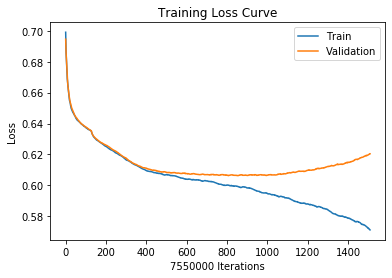

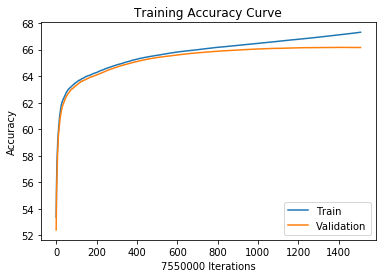

Training Accuracy at epoch 7: 67.3074834437086
Validation Accuracy epoch 7: 66.15740397350993


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/05272020.pth
Starting epoch: 8  with learning rate:  [0.06561000000000002]


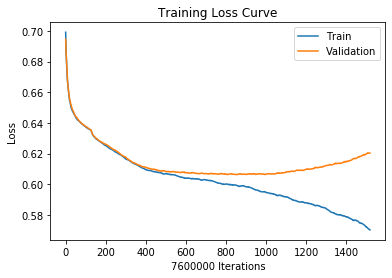

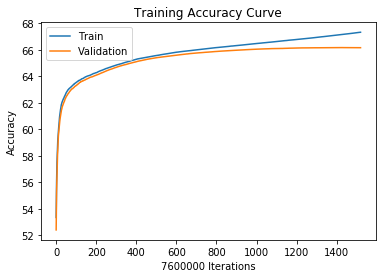

Training Accuracy at epoch 8: 67.32396052631579
Validation Accuracy epoch 8: 66.15847368421052


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


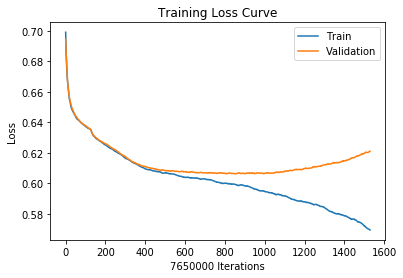

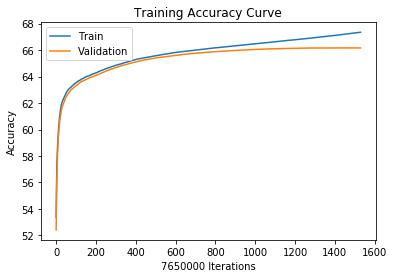

Training Accuracy at epoch 8: 67.34332026143791
Validation Accuracy epoch 8: 66.15653594771241


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


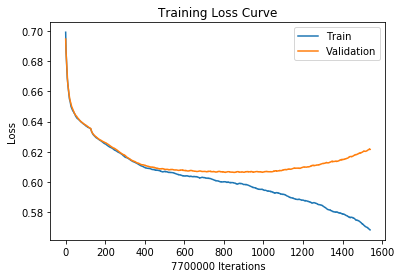

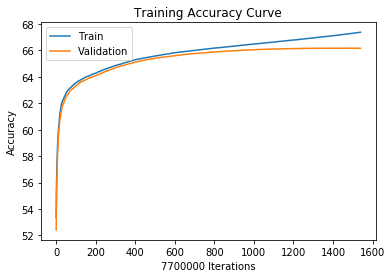

Training Accuracy at epoch 8: 67.36694805194806
Validation Accuracy epoch 8: 66.15675324675324


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


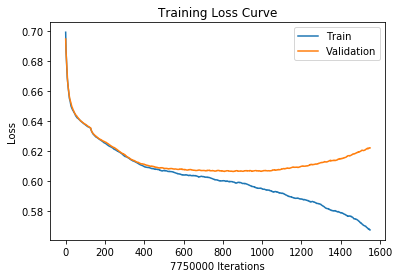

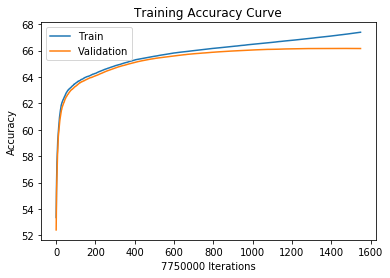

Training Accuracy at epoch 8: 67.38825806451612
Validation Accuracy epoch 8: 66.1556129032258


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


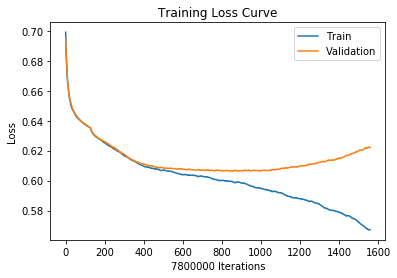

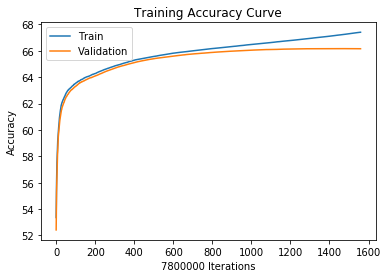

Training Accuracy at epoch 8: 67.4040641025641
Validation Accuracy epoch 8: 66.15408974358975


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


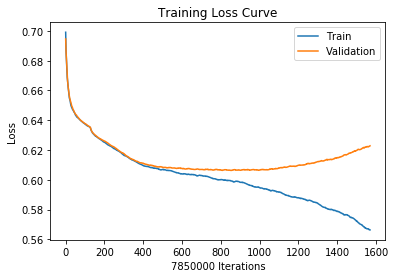

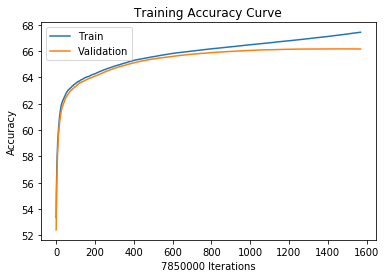

Training Accuracy at epoch 8: 67.42515923566879
Validation Accuracy epoch 8: 66.15105732484076


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


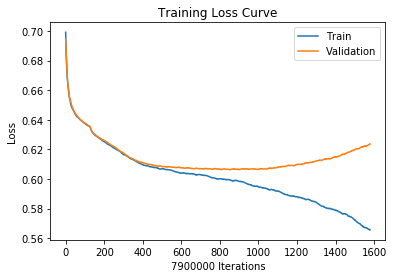

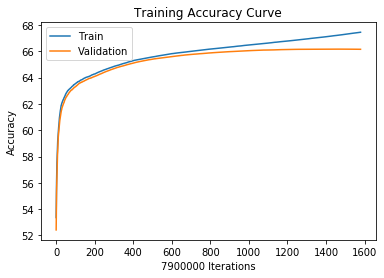

Training Accuracy at epoch 8: 67.44543037974684
Validation Accuracy epoch 8: 66.15012658227847


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


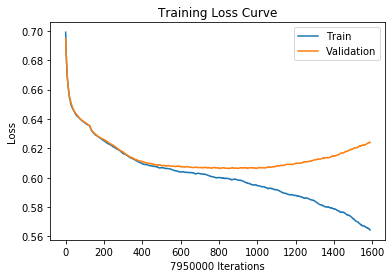

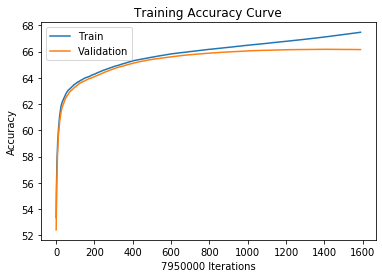

Training Accuracy at epoch 8: 67.46762264150944
Validation Accuracy epoch 8: 66.15012578616353


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


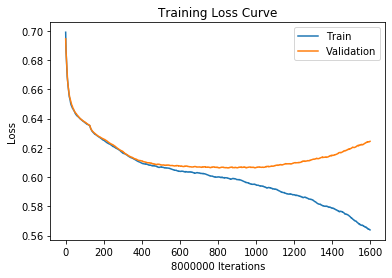

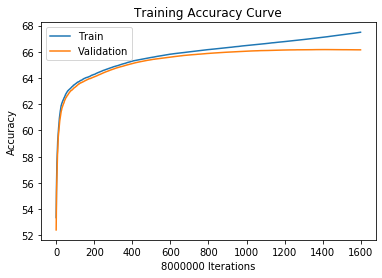

Training Accuracy at epoch 8: 67.4893
Validation Accuracy epoch 8: 66.148625


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


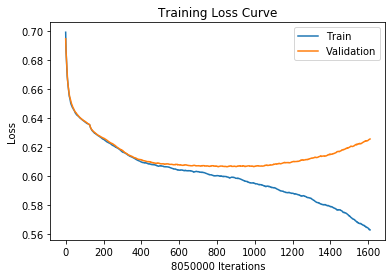

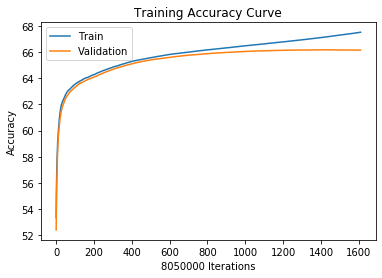

Training Accuracy at epoch 8: 67.51136645962733
Validation Accuracy epoch 8: 66.14505590062112


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


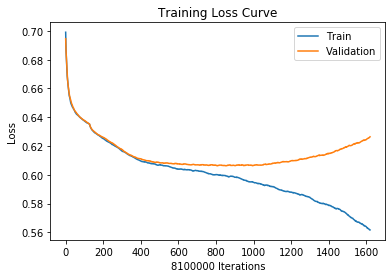

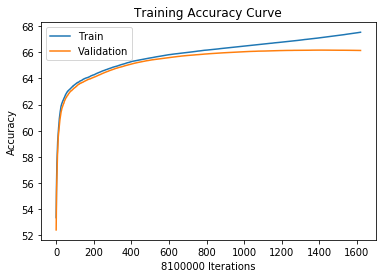

Training Accuracy at epoch 8: 67.53375308641975
Validation Accuracy epoch 8: 66.14056790123456


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [ ]:
model = SingleAlphabetComplexNet()
model_name = model.name
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/05272020.pth' %model_name
single_alphabet = True
NUM_EPOCHS = 10
BATCH_SIZE = 128
gamma = 1e-1
classifier(model, binary_train, binary_val, gamma, NUM_EPOCHS, BATCH_SIZE, single_alphabet, checkpoint, save_path)